<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/001-EDA-LiDAR_Branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis - LiDAR Branch
Extract and analyze LiDAR scan data from ROS bags collected by a Jetson-based robot

## <font color='#2E86AB'>▼ 1. Initialization and Setup</font>

In [1]:
# Install required packages
!pip install --quiet rosbags opencv-python pillow numpy matplotlib tqdm seaborn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 10.1 MB/s eta 0:00:00


In [2]:
# Import libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
import io
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore
import os
from pathlib import Path
print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
# Initialize typestore for ROS1 message deserialization
typestore = get_typestore(Stores.ROS1_NOETIC)
print("Typestore initialized for ROS1")

Typestore initialized for ROS1


## <font color='#2E86AB'>▼ 2. Storage Mounting</font>

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color='#2E86AB'>▼ 3. ROS Bag Load</font>

In [6]:
# Specify the path to the sessions folder
data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/"

In [7]:
# Specify the session
session = '20251016_133216'
print(f"Using session: {session}")

Using session: 20251016_133216


In [8]:
working_folder = data_path + 'session_' + session
bag_name = 'session_data.bag'

# Change to the specified subfolder
os.chdir(working_folder)
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251016_133216


In [9]:
bag_file = working_folder + '/' + bag_name
print(f"Bag file name: {bag_name}")

# Set bag_path for the rest of the notebook
bag_path = bag_file

Bag file name: session_data.bag


## <font color='#2E86AB'>▼ 4. ROS Bag Basic EDA</font>

### 1. Basic Bag Information

In [10]:
# Open the bag and get basic information
print("=" * 60)
print("BASIC BAG INFORMATION")
print("=" * 60)

with Reader(bag_path) as reader:
    # Get basic statistics
    duration = reader.duration * 1e-9  # Convert to seconds
    duration_sec = duration
    total_messages = reader.message_count

    # Get file size
    file_size_bytes = os.path.getsize(bag_path)
    file_size_mb = file_size_bytes / (1024 * 1024)

    # Calculate average message rate
    avg_message_rate = total_messages / duration if duration > 0 else 0

    print(f"\n📁 File: {bag_name}")
    print(f"💾 Size: {file_size_mb:.2f} MB")
    print(f"⏱️  Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
    print(f"📬 Total Messages: {total_messages:,}")
    print(f"📊 Average Rate: {avg_message_rate:.2f} msg/sec")

BASIC BAG INFORMATION

📁 File: session_data.bag
💾 Size: 34.35 MB
⏱️  Duration: 463.17 seconds (7.72 minutes)
📬 Total Messages: 98,205
📊 Average Rate: 212.03 msg/sec


### 2. Topic Analysis

In [11]:
# Analyze topics and connections
print("=" * 60)
print("TOPIC ANALYSIS (ROS1 BAG)")
print("=" * 60)

import struct

def parse_tf_binary(rawdata):
    """Parse TF message from raw bytes"""
    transforms = set()
    for start_offset in [0, 4, 8, 12, 16]:
        try:
            offset = start_offset
            array_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
            if array_len > 100 or array_len == 0:
                continue
            offset += 4
            for _ in range(min(array_len, 10)):
                if offset + 100 > len(rawdata):
                    break
                frame_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if frame_len > 0 and frame_len < 100:
                    offset += 4
                    parent = rawdata[offset:offset+frame_len].decode('utf-8', errors='ignore').strip('/')
                    offset += frame_len
                    child_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                    if child_len > 0 and child_len < 100:
                        offset += 4
                        child = rawdata[offset:offset+child_len].decode('utf-8', errors='ignore').strip('/')
                        if parent and child:
                            transforms.add(f"{parent}→{child}")
                        offset += child_len + 48
                else:
                    break
            if transforms:
                return transforms
        except:
            continue
    return transforms

# Get basic topic information with connection indices
with Reader(bag_path) as reader:
    topics_data = []
    connection_map = {}  # Store connection index mapping

    for conn_idx, connection in enumerate(reader.connections):
        topics_data.append({
            'Topic': connection.topic,
            'Message Type': connection.msgtype,
            'Count': connection.msgcount,
            'Connection_Index': conn_idx,
            'Description': ""
        })
        # Map for later use
        connection_map[conn_idx] = {'topic': connection.topic, 'msgtype': connection.msgtype, 'msgcount': connection.msgcount}

    df_topics = pd.DataFrame(topics_data)

# Analyze TF connections
print("\n🔍 Analyzing TF connections...")
with Reader(bag_path) as reader:
    tf_connection_data = {}

    for conn_idx, conn in enumerate(reader.connections):
        if conn.topic in ['/tf', '/tf_static']:
            tf_connection_data[conn_idx] = {'transforms': set(), 'samples': 0}

    for connection, timestamp, rawdata in reader.messages():
        if connection.topic in ['/tf', '/tf_static']:
            conn_idx = None
            for idx, conn in enumerate(reader.connections):
                if (conn.topic == connection.topic and
                    conn.msgtype == connection.msgtype and
                    conn.msgcount == connection.msgcount):
                    conn_idx = idx
                    break

            if conn_idx is not None and conn_idx in tf_connection_data:
                if tf_connection_data[conn_idx]['samples'] < 10:
                    try:
                        msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                        for tf in msg.transforms:
                            parent = tf.header.frame_id.strip('/')
                            child = tf.child_frame_id.strip('/')
                            tf_connection_data[conn_idx]['transforms'].add(f"{parent}→{child}")
                    except:
                        binary_transforms = parse_tf_binary(rawdata)
                        if binary_transforms:
                            tf_connection_data[conn_idx]['transforms'].update(binary_transforms)
                    tf_connection_data[conn_idx]['samples'] += 1

# Classify TF connections
for idx, row in df_topics.iterrows():
    if row['Topic'] in ['/tf', '/tf_static']:
        conn_idx = row['Connection_Index']

        if conn_idx in tf_connection_data:
            transforms = tf_connection_data[conn_idx]['transforms']

            if transforms:
                transforms_str = ', '.join(sorted(transforms)[:5])
                if len(transforms) > 5:
                    transforms_str += f" (+{len(transforms)-5} more)"

                transforms_lower = ' '.join(transforms).lower()

                if 'map' in transforms_lower and 'odom' in transforms_lower:
                    classification = "SLAM"
                elif 'odom' in transforms_lower and 'base' in transforms_lower:
                    classification = "Odometry"
                elif 'imu' in transforms_lower or 'laser' in transforms_lower or 'camera' in transforms_lower:
                    classification = "Static"
                else:
                    classification = "Other"

                df_topics.at[idx, 'Description'] = f"{classification}: {transforms_str}"
            else:
                freq = row['Count'] / duration_sec
                if freq > 40:
                    classification = "SLAM"
                elif freq > 30:
                    classification = "Odometry"
                elif freq > 15:
                    classification = "Static"
                else:
                    classification = "Other"
                df_topics.at[idx, 'Description'] = f"{classification} (by frequency)"

# Display
df_topics_display = df_topics.drop('Connection_Index', axis=1)
df_topics_display = df_topics_display.sort_values('Count', ascending=False)
df_topics_display['Frequency (Hz)'] = df_topics_display['Count'] / duration_sec

print(f"\n📊 Total Connections: {len(df_topics_display)}")
print(f"📊 Unique Topics: {df_topics_display['Topic'].nunique()}")
print(f"\n{df_topics_display.to_string(index=False)}")

df_topics_display.to_csv('topic_statistics.csv', index=False)
print(f"\n✅ Topic statistics saved to: topic_statistics.csv")

unique_topics = df_topics_display['Topic'].tolist()

TOPIC ANALYSIS (ROS1 BAG)

🔍 Analyzing TF connections...

📊 Total Connections: 13
📊 Unique Topics: 10

                          Topic                         Message Type  Count             Description  Frequency (Hz)
                            /tf               tf2_msgs/msg/TFMessage  20459     SLAM (by frequency)       44.172132
                            /tf               tf2_msgs/msg/TFMessage  17614 Odometry (by frequency)       38.029617
                            /tf               tf2_msgs/msg/TFMessage  16294 Odometry (by frequency)       35.179663
                       /cmd_vel              geometry_msgs/msg/Twist  11418                               24.652104
                           /imu                  sensor_msgs/msg/Imu   9553                               20.625464
                            /tf               tf2_msgs/msg/TFMessage   8928   Static (by frequency)       19.276054
         /csi_cam_0/camera_info           sensor_msgs/msg/CameraInfo   7785          

### 3. Sample Raw Message

In [12]:
# Print a sample raw message from the LiDAR topic
print("=" * 60)
print("SAMPLE RAW MESSAGE")
print("=" * 60)

with Reader(bag_path) as reader:
    # Find the LiDAR topic
    lidar_topics = [conn.topic for conn in reader.connections if 'scan' in conn.topic.lower()]

    if lidar_topics:
        target_topic = lidar_topics[0]
        print(f"\n📡 Displaying sample message from: {target_topic}\n")

        # Get first message from LiDAR topic
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == target_topic:
                try:
                    # Deserialize the message
                    msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                    print(f"Message Type: {connection.msgtype}")
                    print(f"Timestamp: {timestamp * 1e-9:.6f} seconds\n")
                    print("Message Structure:")
                    print("-" * 60)

                    # Print header
                    if hasattr(msg, 'header'):
                        print(f"Header:")
                        print(f"  seq: {msg.header.seq}")
                        print(f"  stamp: {msg.header.stamp.sec}.{msg.header.stamp.nanosec}")
                        print(f"  frame_id: '{msg.header.frame_id}'\n")

                    # Print scan parameters
                    print(f"Scan Parameters:")
                    if hasattr(msg, 'angle_min'):
                        print(f"  angle_min: {msg.angle_min:.6f} rad ({np.rad2deg(msg.angle_min):.2f}°)")
                    if hasattr(msg, 'angle_max'):
                        print(f"  angle_max: {msg.angle_max:.6f} rad ({np.rad2deg(msg.angle_max):.2f}°)")
                    if hasattr(msg, 'angle_increment'):
                        print(f"  angle_increment: {msg.angle_increment:.6f} rad ({np.rad2deg(msg.angle_increment):.4f}°)")
                    if hasattr(msg, 'time_increment'):
                        print(f"  time_increment: {msg.time_increment:.9f} seconds")
                    if hasattr(msg, 'scan_time'):
                        print(f"  scan_time: {msg.scan_time:.6f} seconds")
                    if hasattr(msg, 'range_min'):
                        print(f"  range_min: {msg.range_min:.3f} m")
                    if hasattr(msg, 'range_max'):
                        print(f"  range_max: {msg.range_max:.3f} m\n")

                    # Print range data sample
                    if hasattr(msg, 'ranges'):
                        ranges = np.array(msg.ranges)
                        print(f"Range Data:")
                        print(f"  Total points: {len(ranges)}")
                        print(f"  First 10 ranges: {ranges[:10]}")
                        print(f"  Last 10 ranges: {ranges[-10:]}")
                        print(f"  Valid ranges: {np.sum(np.isfinite(ranges))} ({100*np.sum(np.isfinite(ranges))/len(ranges):.1f}%)\n")

                    # Print intensity data sample if available
                    if hasattr(msg, 'intensities') and len(msg.intensities) > 0:
                        intensities = np.array(msg.intensities)
                        print(f"Intensity Data:")
                        print(f"  Total points: {len(intensities)}")
                        print(f"  First 10 intensities: {intensities[:10]}")
                        print(f"  Min: {np.min(intensities):.2f}, Max: {np.max(intensities):.2f}, Mean: {np.mean(intensities):.2f}")

                    break  # Only show first message

                except Exception as e:
                    print(f"❌ Error deserializing message: {e}")
                    break
    else:
        print("\n⚠️ No LiDAR scan topic found in bag file")

SAMPLE RAW MESSAGE

📡 Displaying sample message from: /scan

Message Type: sensor_msgs/msg/LaserScan
Timestamp: 1760649872.685543 seconds

Message Structure:
------------------------------------------------------------
Header:
  seq: 1610
  stamp: 1760649849.759624225
  frame_id: 'laser_frame'

Scan Parameters:
  angle_min: -3.141593 rad (-180.00°)
  angle_max: 3.141593 rad (180.00°)
  angle_increment: 0.005483 rad (0.3141°)
  time_increment: 0.000117000 seconds
  scan_time: 0.134082 seconds
  range_min: 0.150 m
  range_max: 12.000 m

Range Data:
  Total points: 1147
  First 10 ranges: [   inf    inf    inf    inf    inf    inf    inf    inf 13.392 13.392]
  Last 10 ranges: [inf inf inf inf inf inf inf inf inf inf]
  Valid ranges: 877 (76.5%)

Intensity Data:
  Total points: 1147
  First 10 intensities: [ 0.  0.  0.  0.  0.  0.  0.  0. 47. 47.]
  Min: 0.00, Max: 47.00, Mean: 35.94


### 4. Message Frequency Distribution

In [13]:
# Analyze message frequency distribution
print("=" * 60)
print("MESSAGE FREQUENCY DISTRIBUTION")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_timestamps = defaultdict(list)  # Track by connection index
    topic_timestamps = defaultdict(list)  # Also track by topic for backward compatibility

    print("\nCollecting timestamps...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        topic = connection.topic
        timestamp_sec = timestamp * 1e-9

        # Add to topic_timestamps
        topic_timestamps[topic].append(timestamp_sec)

        # Find connection index for detailed tracking
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_timestamps[conn_idx].append(timestamp_sec)

    print("\n📈 Inter-Message Interval Statistics (by connection):")
    print(f"{'Topic':<40} {'Description':<30} {'Mean (ms)':<12} {'Std (ms)':<12}")
    print("-" * 94)

    for conn_idx in sorted(connection_timestamps.keys()):
        timestamps = connection_timestamps[conn_idx]
        if len(timestamps) > 1:
            intervals = np.diff(timestamps) * 1000

            # Get topic info from df_topics
            topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]
            topic_name = topic_row['Topic']
            description = topic_row['Description'][:28] if topic_row['Description'] else ''

            print(f"{topic_name:<40} {description:<30} {np.mean(intervals):<12.2f} {np.std(intervals):<12.2f}")

MESSAGE FREQUENCY DISTRIBUTION



100%|██████████| 98205/98205 [00:01<00:00, 87545.92it/s]



📈 Inter-Message Interval Statistics (by connection):
Topic                                    Description                    Mean (ms)    Std (ms)    
----------------------------------------------------------------------------------------------
/csi_cam_0/camera_info                                                  59.50        500.15      
/constraint_list                                                        2766.79      10945.50    
/csi_cam_0/image_raw/compressed                                         4480.40      3405.35     
/imu                                                                    46.95        447.40      
/odom                                                                   111.79       1323.80     
/scan                                                                   1427.87      3374.64     
/tf                                      Odometry (by frequency)        27.52        258.56      
/tf                                      SLAM (by frequency)       

### 5. Message Size Distribution Analysis

In [14]:
# Analyze message sizes per connection
print("=" * 60)
print("MESSAGE SIZE ANALYSIS")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_sizes = defaultdict(list)

    print("\nCollecting message sizes...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        # Find connection index
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_sizes[conn_idx].append(len(rawdata))

    # Calculate statistics
    size_stats = []
    for conn_idx, sizes in connection_sizes.items():
        sizes_array = np.array(sizes)
        topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]

        size_stats.append({
            'Topic': topic_row['Topic'],
            'Description': topic_row['Description'][:40] if topic_row['Description'] else '',
            'Avg Size (bytes)': np.mean(sizes_array),
            'Total Size (MB)': np.sum(sizes_array) / (1024 * 1024)
        })

    df_sizes = pd.DataFrame(size_stats)
    df_sizes = df_sizes.sort_values('Total Size (MB)', ascending=False)

    print("\n📏 Message Size Statistics:")
    print(df_sizes.to_string(index=False))

    df_sizes.to_csv('message_size_statistics.csv', index=False)

MESSAGE SIZE ANALYSIS



100%|██████████| 98205/98205 [00:01<00:00, 69440.04it/s]



📏 Message Size Statistics:
                          Topic             Description  Avg Size (bytes)  Total Size (MB)
/csi_cam_0/image_raw/compressed                              35867.980000         3.420637
                           /imu                                325.000000         2.960896
                            /tf Odometry (by frequency)        181.000000         2.812590
                          /scan                               9239.000000         2.775464
                          /odom                                719.000000         2.751681
          /trajectory_node_list                               6978.941463         2.728811
         /csi_cam_0/camera_info                                361.000000         2.680192
                            /tf     SLAM (by frequency)        107.000000         2.087701
               /constraint_list                              19224.550459         1.998402
                            /tf Odometry (by frequency)       

In [15]:
# Generate ROS Bag Basic EDA summary report
print("=" * 60)
print("ROS BAG BASIC EDA - SUMMARY REPORT")
print("=" * 60)

rosbag_summary = f"""
📊 ROS BAG BASIC EDA SUMMARY
{'='*60}

FILE INFORMATION:
  • File: {bag_name}
  • Size: {file_size_mb:.2f} MB
  • Duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)

MESSAGE STATISTICS:
  • Total Messages: {total_messages:,}
  • Unique Topics: {len(unique_topics)}
  • Message Types: {df_topics['Message Type'].nunique()}
  • Average Rate: {avg_message_rate:.2f} msg/sec

DATA QUALITY:
  • Average Data Rate: {file_size_mb / (duration_sec/60):.2f} MB/min

TOP 3 TOPICS BY SIZE:
"""

for idx, row in df_sizes.head(3).iterrows():
    rosbag_summary += f"  {idx+1}. {row['Topic']}: {row['Total Size (MB)']:.2f} MB\n"

print(rosbag_summary)

# Save report
with open('rosbag_basic_eda_summary.txt', 'w') as f:
    f.write(rosbag_summary)

print("\n✅ ROS Bag Basic EDA summary saved to: rosbag_basic_eda_summary.txt")

ROS BAG BASIC EDA - SUMMARY REPORT

📊 ROS BAG BASIC EDA SUMMARY

FILE INFORMATION:
  • File: session_data.bag
  • Size: 34.35 MB
  • Duration: 463.17 seconds (7.72 minutes)

MESSAGE STATISTICS:
  • Total Messages: 98,205
  • Unique Topics: 13
  • Message Types: 9
  • Average Rate: 212.03 msg/sec

DATA QUALITY:
  • Average Data Rate: 4.45 MB/min

TOP 3 TOPICS BY SIZE:
  3. /csi_cam_0/image_raw/compressed: 3.42 MB
  4. /imu: 2.96 MB
  7. /tf: 2.81 MB


✅ ROS Bag Basic EDA summary saved to: rosbag_basic_eda_summary.txt


## <font color='#2E86AB'>▼ 5. LiDAR Topic Basic EDA</font>

### Hardware Documentation: RPLiDAR System

---

## 🔵 Hardware Specifications

**LiDAR Sensor: SLAMTEC RPLIDAR A1M8-R6**

The Waveshare AI ROS Pro Kit is equipped with the SLAMTEC RPLIDAR A1M8-R6, a budget-friendly 360° laser scanner designed for robotics education and SLAM applications.

**Model Information:**
- **Full Model:** RPLIDAR A1M8-R6 (latest revision)
- **Manufacturer:** SLAMTEC (Shanghai Slamtec Co., Ltd.)
- **Technology:** Laser Triangulation Ranging
- **Product Line:** Entry-level 2D LiDAR

**Range Performance:**
- **Distance Range:** 0.15m - 12m
  - Effective range: 6-12m (depending on surface reflectivity)
  - White/light surfaces: Up to 12m
  - Dark surfaces: 6-8m typical
- **Distance Resolution:** <0.5mm (0.2cm typical)
- **Distance Accuracy:** ±0.5mm to ±1cm
- **Angular Range:** 0° - 360° (full rotation)
- **Angular Resolution:** ≤1° (approximately 360 points per scan)

**Scanning Performance:**
- **Sample Rate:** Up to 8,000 samples/second (maximum)
- **Sample Frequency:** 2,000-2,010 Hz per individual measurement
- **Sample Duration:** 0.5ms per point
- **Scan Rate:** 1-10 Hz (user configurable via PWM)
  - **Typical/Default:** 5.5 Hz
  - **Configurable Range:** 2-10 Hz
- **Rotation Direction:** Clockwise

**Laser Specifications:**
- **Laser Type:** Infrared laser diode
- **Wavelength:** 775-795nm (near-infrared)
- **Laser Power:** <5mW
- **Safety Class:** Class 1 (Eye Safe)
- **Beam Divergence:** Optimized for triangulation

**Physical Specifications:**
- **Dimensions:** 96.8mm (W) × 70mm (D) × 55mm (H)
- **Weight:** 170g (including motor and electronics)
- **Housing:** Protective enclosure with rotating core

**Electrical & Interface:**
- **Power Supply:** 5V DC
- **Interface Options:**
  - Primary: 3.3V TTL UART (5-pin, 2.0mm pitch connector)
  - Alternative: USB via included adapter
- **UART Baud Rate:** 115200 bps (default) or 57600 bps (with adapter)
- **Motor Control:** PWM input for scan rate adjustment
- **On Jetson Nano:** Communicates via `/dev/ttyACM1`

**Unique Technology - OPTMAG:**
- Wireless power transmission (no slip rings)
- Optical data communication
- Extended lifespan (eliminates mechanical wear)
- Maintenance-free operation

---

## 📡 ROS Topics Published

The RPLIDAR A1M8 publishes one primary topic:

### `/scan` (or `/rplidar/scan`)

**Message Type:** `sensor_msgs/LaserScan`

**Message Fields:**

**Header:**
- `stamp` - Timestamp of scan start
- `frame_id` - Coordinate frame (typically "laser", "base_laser", or "laser_frame")

**Scan Configuration:**
- `angle_min` - Start angle (radians, typically -π ≈ -3.14159)
- `angle_max` - End angle (radians, typically +π ≈ +3.14159)
- `angle_increment` - Angular step between measurements (radians, ~0.0174533 = 1°)
- `time_increment` - Time between measurements (~0.0005 sec = 0.5ms)
- `scan_time` - Time for complete rotation
  - At 5.5 Hz: ~0.182 seconds
  - At 10 Hz: ~0.1 seconds

**Range Configuration:**
- `range_min` - Minimum valid range (0.15 meters)
- `range_max` - Maximum valid range (12.0 meters)

**Data Arrays:**
- `ranges[]` - Array of distance measurements in meters
  - Array length: ~360 measurements (one per degree)
  - Invalid readings: `inf` (no return/out of range) or `nan` (sensor error)
- `intensities[]` - Signal strength values (may be empty or populated)

---

## 📊 Expected Data Characteristics for A1M8

**Normal Operation:**
- **Points per scan:** ~360 points (360° ÷ 1° resolution)
- **Scan frequency:** 5.5 Hz typical (configurable 2-10 Hz)
- **Scan period:** ~182ms at 5.5 Hz, ~100ms at 10 Hz
- **Data completeness:** 85-95% valid readings typical
- **Sample rate:** 8,000 samples/sec maximum
- **Points per revolution:** Varies with scan rate (more points at slower rates)

**Range Performance by Distance:**
- **0.15m - 6m:** Highly reliable, all surface types
- **6m - 12m:** Reliable for light-colored surfaces
- **>12m:** Returns `inf` (out of range)
- **<0.15m:** Returns `nan` or `0` (too close)

**Invalid Readings:**
- `inf` values: No obstacle detected (beyond max range or no reflection)
- `nan` values: Sensor error or invalid measurement
- Out-of-range values: < 0.15m or > 12.0m
- Typical invalid rate: 5-15% depending on environment

**Surface Material Sensitivity:**
- **Excellent reflection (8-12m):**
  - White walls and surfaces
  - Light-colored materials
  - Paper, cardboard
  - Matte painted surfaces
- **Good reflection (6-10m):**
  - Wood surfaces
  - Concrete
  - Colored surfaces
- **Reduced range (3-6m):**
  - Dark surfaces (black, dark blue, dark brown)
  - Rough textured surfaces
- **Poor/unreliable detection:**
  - Transparent materials (glass, clear acrylic)
  - Mirrors and highly reflective surfaces
  - Shiny metal (angle-dependent)
  - Very dark or light-absorbing materials

**Environmental Factors:**
- **Indoor operation:** Excellent performance
- **Outdoor with shade:** Good performance (6-8m typical)
- **Direct sunlight:** Significantly reduced range and increased noise
- **Dust/fog:** Causes false detections and reduced range
- **Smoke:** Creates phantom obstacles at closer ranges
- **Rain:** Not recommended (water droplets cause errors)

---

## ⚠️ Common Issues to Check - A1M8 Specific

1. **Scan Rate Variations:** Check if scan time is consistent (~182ms at 5.5Hz)
2. **Angular Coverage:** Verify full 360° coverage (no missing angles)
3. **Data Completeness:** Monitor valid vs invalid point ratio (should be >85%)
4. **Range Consistency:** Check for sudden jumps or noise in measurements
5. **Motor Speed Stability:** Ensure consistent rotation (no jitter in scan_time)
6. **Communication Issues:**
   - Check `/dev/ttyACM1` connection
   - Verify baud rate (115200 or 57600)
   - Look for USB disconnections
7. **Mounting Vibration:** Can cause measurement noise (secure firmly)
8. **Power Supply:** Ensure stable 5V (voltage drops affect motor speed)
9. **Reflective Artifacts:** Mirrors can cause ghost readings
10. **Sunlight Interference:** Avoid direct sunlight exposure

**Known Limitations:**
- No blind spot at 0° (unlike some older models)
- Cannot detect transparent or mirror surfaces
- Reduced accuracy at maximum range (>10m)
- Sensitive to ambient lighting in outdoor environments

---

## 🔍 Expected Values for Waveshare AI ROS Pro Kit

```python
# Typical LaserScan message structure for RPLIDAR A1M8
header:
  frame_id: "laser_frame" or "base_laser"
angle_min: -3.14159 (radians = -180°)
angle_max: 3.14159 (radians = +180°)
angle_increment: 0.0174533 (radians ≈ 1°)
time_increment: 0.0005 (sec = 0.5ms)
scan_time: 0.182 (sec for 5.5 Hz) or 0.1 (sec for 10 Hz)
range_min: 0.15 (meters)
range_max: 12.0 (meters)
ranges: [~360 measurements]
intensities: [optional - may be empty or ~360 values]
```

**Performance Benchmarks:**
- **Indoor effective range:** 8-12m typical
- **Outdoor effective range:** 6-8m in shade, 3-5m in bright light
- **Angular accuracy:** ±1° typical
- **Distance accuracy:** ±5mm to ±10mm depending on range
- **Measurement rate:** 8,000 samples/sec ÷ 360° ≈ 22 samples per degree
- **Update rate:** 5.5 Hz typical (182ms per full scan)
- **Data latency:** <10ms typical

**Comparison to A2/A3 Models:**
- A1M8: 12m range, 8K samples/sec, 5.5Hz typical
- A2: 18m range, 8K samples/sec, 10Hz typical
- A3: 25m range, 16K samples/sec, 20Hz typical

The A1M8 is the entry-level model, perfect for indoor robotics education and hobbyist SLAM applications.

### LiDAR Scan Topic Inspection

In [16]:
# Find and inspect LiDAR scan topics
print("=" * 60)
print("LIDAR SCAN TOPIC INSPECTION")
print("=" * 60)

# Find scan topics
scan_topics = []
for topic in unique_topics:
    if 'scan' in topic.lower() or 'lidar' in topic.lower():
        scan_topics.append(topic)

if scan_topics:
    print(f"\n✓ Found {len(scan_topics)} scan topic(s): {scan_topics}")
    lidar_topic = scan_topics[0]
else:
    print("\n⚠️ No scan topics found!")
    print("Available topics:", unique_topics)
    lidar_topic = None

if lidar_topic:
    # Parse first message to get scan parameters
    with Reader(bag_path) as reader:
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == lidar_topic:
                try:
                    msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                    print("\n\n🔵 LIDAR SCAN PARAMETERS:")
                    print("=" * 60)

                    print("\n📐 Angular Configuration:")
                    print(f"   Angle Min: {msg.angle_min:.6f} rad ({np.rad2deg(msg.angle_min):.2f}°)")
                    print(f"   Angle Max: {msg.angle_max:.6f} rad ({np.rad2deg(msg.angle_max):.2f}°)")
                    print(f"   Angle Increment: {msg.angle_increment:.6f} rad ({np.rad2deg(msg.angle_increment):.4f}°)")
                    fov = np.rad2deg(msg.angle_max - msg.angle_min)
                    print(f"   Total FOV: {fov:.2f}°")
                    print(f"   Points per Scan: {len(msg.ranges)}")

                    print("\n📏 Range Configuration:")
                    print(f"   Min Range: {msg.range_min:.2f} m")
                    print(f"   Max Range: {msg.range_max:.2f} m")

                    print("\n⏱️ Timing Parameters:")
                    print(f"   Time Increment: {msg.time_increment*1000:.4f} ms per measurement")
                    print(f"   Scan Time: {msg.scan_time:.4f} seconds")
                    expected_freq = 1/msg.scan_time if msg.scan_time > 0 else 0
                    print(f"   Expected Scan Rate: {expected_freq:.2f} Hz")

                    # Analyze first scan
                    ranges = np.array(msg.ranges)
                    valid_mask = np.isfinite(ranges) & (ranges >= msg.range_min) & (ranges <= msg.range_max)
                    valid_count = np.sum(valid_mask)

                    print("\n📊 Sample Scan Data:")
                    print(f"   Valid Points: {valid_count} / {len(ranges)} ({100*valid_count/len(ranges):.1f}%)")
                    if valid_count > 0:
                        print(f"   Range - Min: {np.min(ranges[valid_mask]):.2f} m")
                        print(f"   Range - Mean: {np.mean(ranges[valid_mask]):.2f} m")
                        print(f"   Range - Max: {np.max(ranges[valid_mask]):.2f} m")

                    # Check for intensity data
                    if hasattr(msg, 'intensities') and len(msg.intensities) > 0:
                        print(f"\n   Intensity Data: Available ({len(msg.intensities)} values)")
                    else:
                        print(f"\n   Intensity Data: Not available")

                    break
                except Exception as e:
                    print(f"\n⚠️ Error parsing scan message: {e}")
                    break

LIDAR SCAN TOPIC INSPECTION

✓ Found 1 scan topic(s): ['/scan']


🔵 LIDAR SCAN PARAMETERS:

📐 Angular Configuration:
   Angle Min: -3.141593 rad (-180.00°)
   Angle Max: 3.141593 rad (180.00°)
   Angle Increment: 0.005483 rad (0.3141°)
   Total FOV: 360.00°
   Points per Scan: 1147

📏 Range Configuration:
   Min Range: 0.15 m
   Max Range: 12.00 m

⏱️ Timing Parameters:
   Time Increment: 0.1170 ms per measurement
   Scan Time: 0.1341 seconds
   Expected Scan Rate: 7.46 Hz

📊 Sample Scan Data:
   Valid Points: 833 / 1147 (72.6%)
   Range - Min: 0.84 m
   Range - Mean: 3.58 m
   Range - Max: 10.42 m

   Intensity Data: Available (1147 values)


### 1. LiDAR Topic Timing Analysis

In [17]:
# Analyze timing characteristics of LiDAR topic
print("=" * 60)
print("LIDAR TOPIC TIMING ANALYSIS")
print("=" * 60)

if lidar_topic and lidar_topic in topic_timestamps:
    scan_timestamps = np.array(topic_timestamps[lidar_topic])

    if len(scan_timestamps) > 1:
        intervals = np.diff(scan_timestamps)
        frequencies = 1.0 / intervals

        print(f"\n📊 Timing Statistics for {lidar_topic}:")
        print(f"   Total Scans: {len(scan_timestamps)}")
        print(f"   Duration: {scan_timestamps[-1] - scan_timestamps[0]:.2f} seconds")

        print(f"\n⏱️ Inter-Scan Intervals:")
        print(f"   Mean: {np.mean(intervals)*1000:.2f} ms")
        print(f"   Std Dev: {np.std(intervals)*1000:.2f} ms")
        print(f"   Min: {np.min(intervals)*1000:.2f} ms")
        print(f"   Max: {np.max(intervals)*1000:.2f} ms")

        print(f"\n📡 Scan Frequency:")
        print(f"   Mean: {np.mean(frequencies):.2f} Hz")
        print(f"   Std Dev: {np.std(frequencies):.2f} Hz")
        print(f"   Jitter (CV): {(np.std(intervals)/np.mean(intervals))*100:.2f}%")

        # Check for dropped scans
        expected_interval = 0.1  # 10 Hz expected
        dropped_threshold = expected_interval * 1.5
        dropped_count = np.sum(intervals > dropped_threshold)
        print(f"\n⚠️ Data Quality:")
        print(f"   Potential dropped scans: {dropped_count} ({100*dropped_count/len(intervals):.2f}%)")
else:
    print("\n⚠️ No timing data available for LiDAR topic")

LIDAR TOPIC TIMING ANALYSIS

📊 Timing Statistics for /scan:
   Total Scans: 315
   Duration: 448.35 seconds

⏱️ Inter-Scan Intervals:
   Mean: 1427.87 ms
   Std Dev: 3374.64 ms
   Min: 0.02 ms
   Max: 53541.24 ms

📡 Scan Frequency:
   Mean: 1745.79 Hz
   Std Dev: 8103.09 Hz
   Jitter (CV): 236.34%

⚠️ Data Quality:
   Potential dropped scans: 295 (93.95%)


### 2. LiDAR Topic Basic EDA Summary Report

In [18]:
# Generate LiDAR Topic Basic EDA summary
print("=" * 60)
print("LIDAR TOPIC BASIC EDA - SUMMARY REPORT")
print("=" * 60)

if lidar_topic:
    # Get topic statistics
    topic_info = df_topics_display[df_topics_display['Topic'] == lidar_topic].iloc[0]
    size_info = df_sizes[df_sizes['Topic'] == lidar_topic].iloc[0] if lidar_topic in df_sizes['Topic'].values else None

    lidar_topic_summary = f"""
🔵 LIDAR TOPIC BASIC EDA SUMMARY
{'='*60}

TOPIC INFORMATION:
  • Topic: {lidar_topic}
  • Message Type: {topic_info['Message Type']}
  • Total Messages: {topic_info['Count']:,}
  • Frequency: {topic_info['Frequency (Hz)']:.2f} Hz

TIMING CHARACTERISTICS:
  • Mean Interval: {np.mean(intervals)*1000:.2f} ms
  • Timing Jitter: {(np.std(intervals)/np.mean(intervals))*100:.2f}%
  • Dropped Scans: {dropped_count} ({100*dropped_count/len(intervals):.2f}%)
"""

    if size_info is not None:
        lidar_topic_summary += f"""
DATA SIZE:
  • Average Size: {size_info['Avg Size (bytes)']:.2f} bytes
  • Total Size: {size_info['Total Size (MB)']:.2f} MB
"""

    print(lidar_topic_summary)

    # Save report
    with open('lidar_topic_basic_eda_summary.txt', 'w') as f:
        f.write(lidar_topic_summary)

    print("\n✅ LiDAR Topic Basic EDA summary saved to: lidar_topic_basic_eda_summary.txt")
else:
    print("\n⚠️ No LiDAR topic found for summary")

LIDAR TOPIC BASIC EDA - SUMMARY REPORT

🔵 LIDAR TOPIC BASIC EDA SUMMARY

TOPIC INFORMATION:
  • Topic: /scan
  • Message Type: sensor_msgs/msg/LaserScan
  • Total Messages: 315
  • Frequency: 0.68 Hz

TIMING CHARACTERISTICS:
  • Mean Interval: 1427.87 ms
  • Timing Jitter: 236.34%
  • Dropped Scans: 295 (93.95%)

DATA SIZE:
  • Average Size: 9239.00 bytes
  • Total Size: 2.78 MB


✅ LiDAR Topic Basic EDA summary saved to: lidar_topic_basic_eda_summary.txt


## <font color='#2E86AB'>▼ 6. LiDAR Scan EDA</font>

### 1. Extract and Display Sample Scans

In [19]:
# Extract all LiDAR scans
print("=" * 60)
print("EXTRACTING LIDAR SCANS")
print("=" * 60)

scans = []
scan_timestamps = []
scan_params = {}

if lidar_topic:
    print(f"\n🔄 Extracting scans from {lidar_topic}...")

    with Reader(bag_path) as reader:
        connections = [x for x in reader.connections if x.topic == lidar_topic]

        for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections)):
            try:
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                # Store first scan parameters
                if not scan_params:
                    scan_params = {
                        'angle_min': msg.angle_min,
                        'angle_max': msg.angle_max,
                        'angle_increment': msg.angle_increment,
                        'time_increment': msg.time_increment,
                        'scan_time': msg.scan_time,
                        'range_min': msg.range_min,
                        'range_max': msg.range_max,
                    }

                scans.append(np.array(msg.ranges))
                scan_timestamps.append(timestamp / 1e9)
            except Exception as e:
                print(f"⚠️ Error parsing scan: {e}")

    scan_timestamps = np.array(scan_timestamps)
    if len(scan_timestamps) > 0:
        scan_timestamps = scan_timestamps - scan_timestamps[0]

    print(f"\n✅ Extracted {len(scans)} LiDAR scans")
    print(f"   Duration: {scan_timestamps[-1]:.2f} seconds")
    print(f"   Points per scan: {len(scans[0]) if len(scans) > 0 else 0}")
else:
    print("\n⚠️ No LiDAR topic available for extraction")

EXTRACTING LIDAR SCANS

🔄 Extracting scans from /scan...


315it [00:00, 3091.44it/s]


✅ Extracted 315 LiDAR scans
   Duration: 448.35 seconds
   Points per scan: 1147


SAMPLE LIDAR SCANS - POLAR VIEW


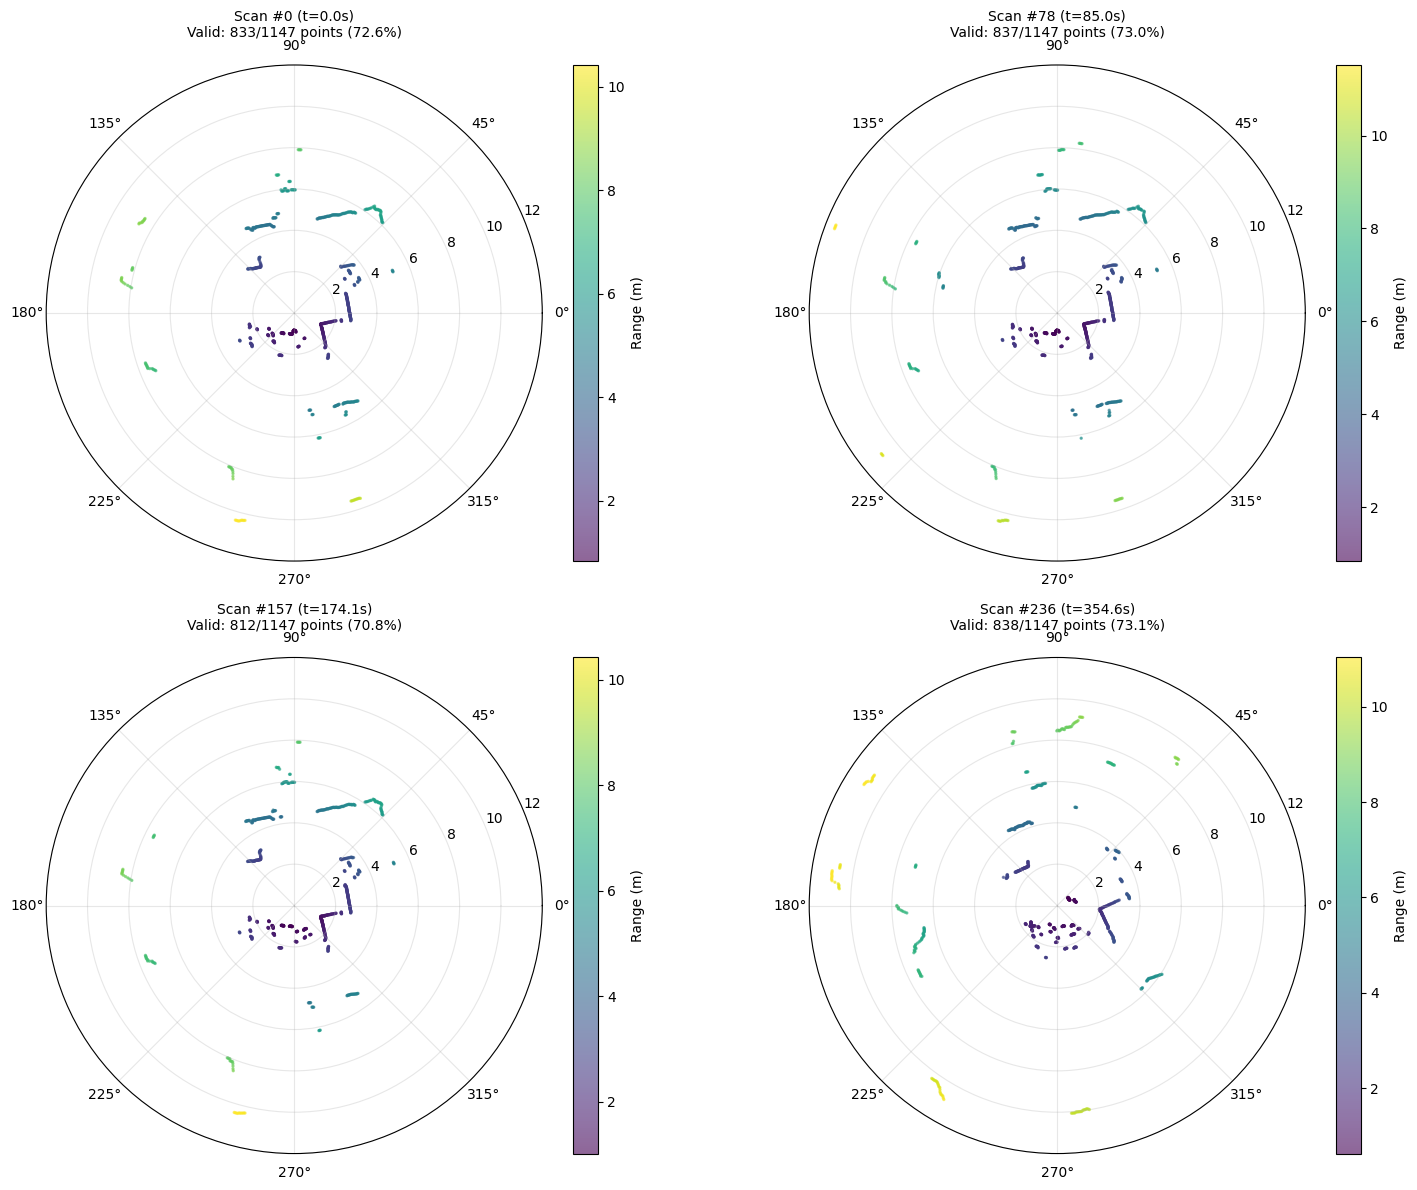


✅ Polar visualization saved to: sample_scans_polar.png

SAMPLE LIDAR SCANS - CARTESIAN VIEW


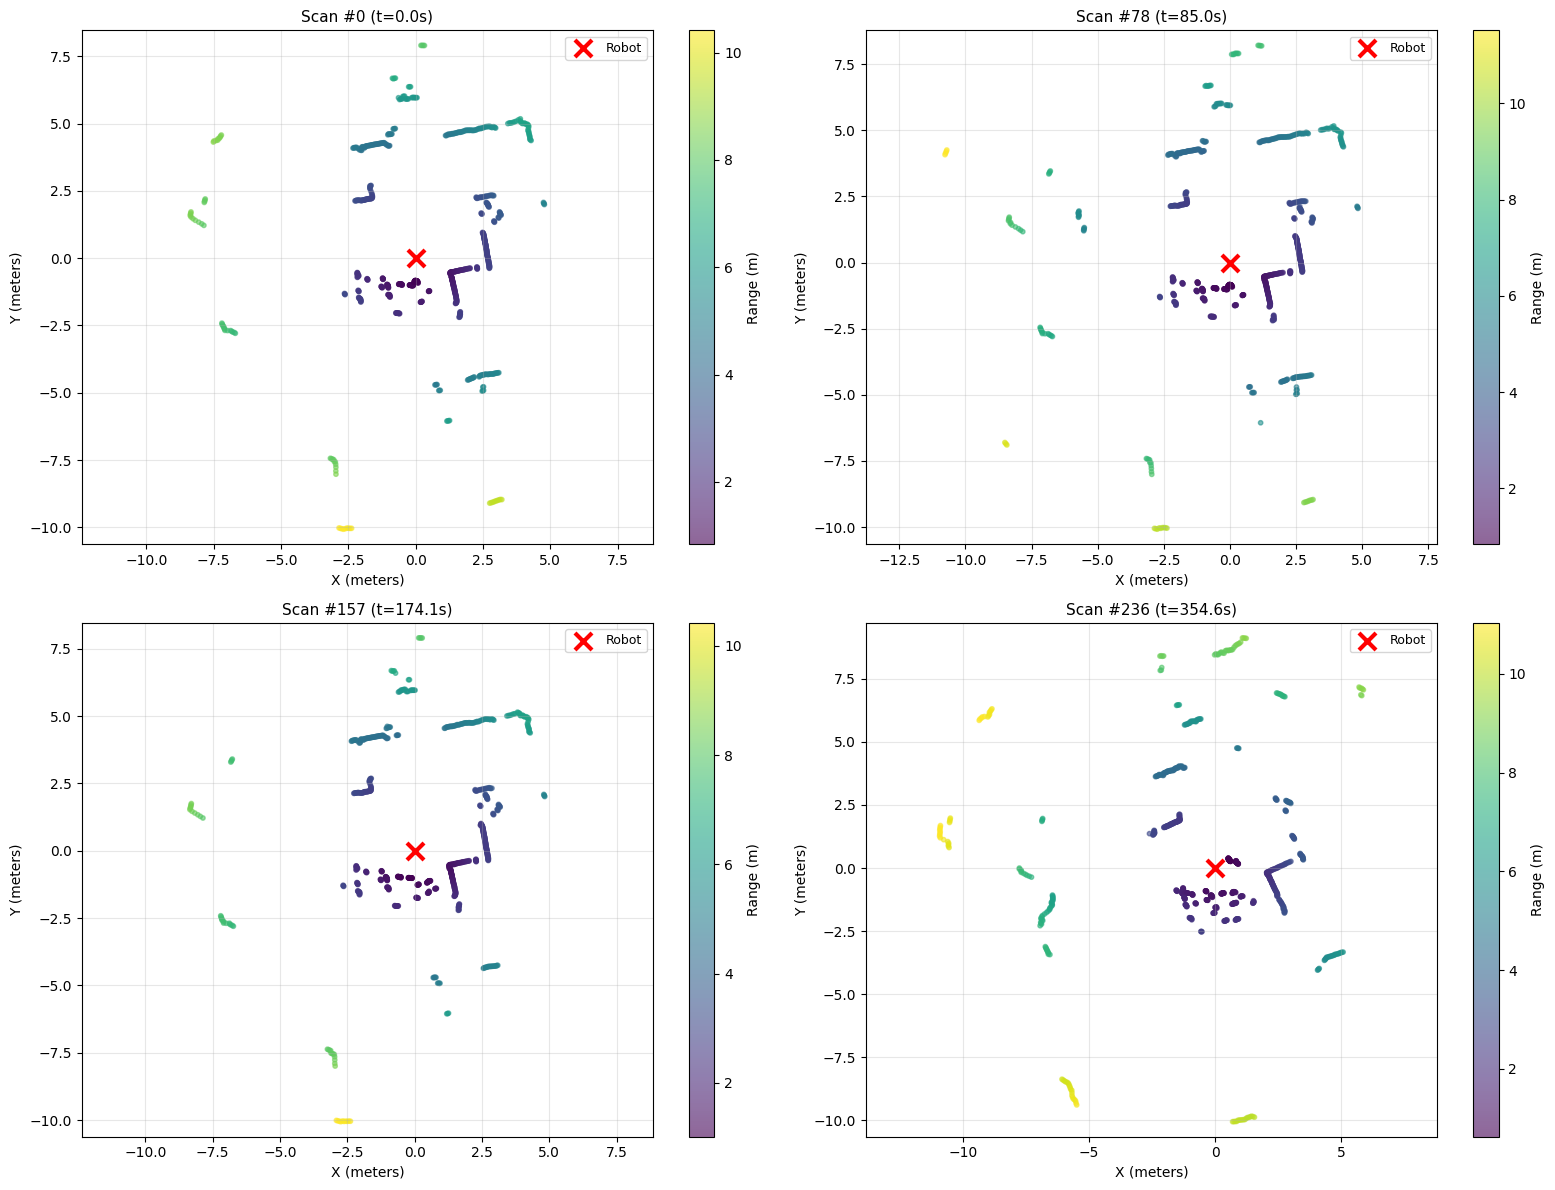


✅ Cartesian visualization saved to: sample_scans_cartesian.png


In [20]:
# Visualize sample scans in polar and Cartesian coordinates
print("=" * 60)
print("SAMPLE LIDAR SCANS - POLAR VIEW")
print("=" * 60)

if len(scans) > 0:
    # Select sample scans
    sample_indices = [0, len(scans)//4, len(scans)//2, 3*len(scans)//4]

    # Polar plots
    fig = plt.figure(figsize=(16, 12))

    for idx, scan_idx in enumerate(sample_indices):
        scan = scans[scan_idx]
        angles = np.arange(len(scan)) * scan_params['angle_increment'] + scan_params['angle_min']

        # Filter valid readings
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        valid_ranges = scan[valid_mask]
        valid_angles = angles[valid_mask]

        # Polar plot
        ax = plt.subplot(2, 2, idx + 1, projection='polar')
        scatter = ax.scatter(valid_angles, valid_ranges, c=valid_ranges, cmap='viridis', s=2, alpha=0.6)
        ax.set_ylim(0, scan_params['range_max'])
        ax.set_title(f"Scan #{scan_idx} (t={scan_timestamps[scan_idx]:.1f}s)\nValid: {np.sum(valid_mask)}/{len(scan)} points ({100*np.sum(valid_mask)/len(scan):.1f}%)",
                     fontsize=10, pad=20)
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Range (m)', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig('sample_scans_polar.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Polar visualization saved to: sample_scans_polar.png")

    # Cartesian plots
    print("\n" + "=" * 60)
    print("SAMPLE LIDAR SCANS - CARTESIAN VIEW")
    print("=" * 60)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, scan_idx in enumerate(sample_indices):
        scan = scans[scan_idx]
        angles = np.arange(len(scan)) * scan_params['angle_increment'] + scan_params['angle_min']

        # Filter valid readings
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        valid_ranges = scan[valid_mask]
        valid_angles = angles[valid_mask]

        # Convert to Cartesian
        x = valid_ranges * np.cos(valid_angles)
        y = valid_ranges * np.sin(valid_angles)

        # Plot
        ax = axes[idx]
        scatter = ax.scatter(x, y, c=valid_ranges, cmap='viridis', s=10, alpha=0.6)
        ax.scatter(0, 0, c='red', s=150, marker='x', linewidths=3, label='Robot', zorder=5)
        ax.set_xlabel('X (meters)', fontsize=10)
        ax.set_ylabel('Y (meters)', fontsize=10)
        ax.set_title(f"Scan #{scan_idx} (t={scan_timestamps[scan_idx]:.1f}s)", fontsize=11)
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        plt.colorbar(scatter, ax=ax, label='Range (m)')

    plt.tight_layout()
    plt.savefig('sample_scans_cartesian.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Cartesian visualization saved to: sample_scans_cartesian.png")
else:
    print("\n⚠️ No scans available for visualization")

### 2. Scan Properties Analysis

SCAN PROPERTIES ANALYSIS

📊 Scan Properties Statistics:
   Total Scans: 315
   Points per Scan: 1147

📈 Valid Points per Scan:
   Mean: 814.0 (71.0%)
   Std Dev: 41.7
   Range: [686, 915]

📉 Invalid Points per Scan:
   Mean: 333.0 (29.0%)
   Std Dev: 41.7

📏 Range Statistics:
   Mean Range: 3.93 m
   Closest Obstacle (overall): 0.31 m
   Furthest Detection (overall): 12.00 m


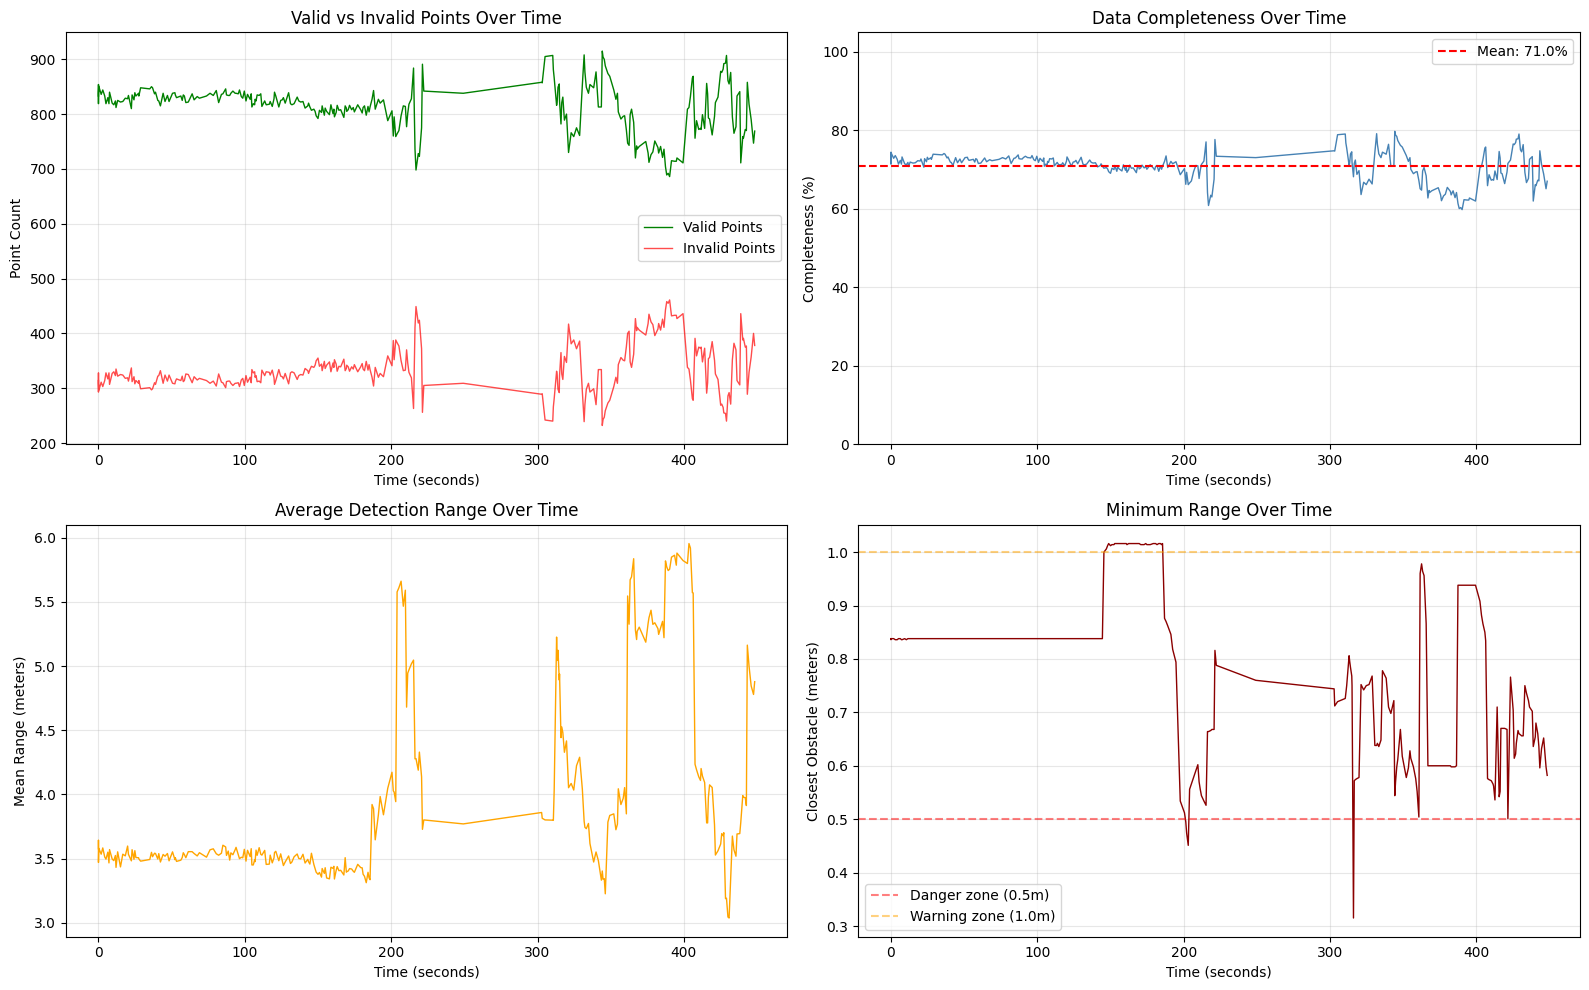


✅ Scan properties analysis saved to: scan_properties.png


In [21]:
# Analyze scan properties
print("=" * 60)
print("SCAN PROPERTIES ANALYSIS")
print("=" * 60)

if len(scans) > 0:
    # Calculate per-scan statistics
    valid_counts = []
    invalid_counts = []
    mean_ranges = []
    min_ranges = []
    max_ranges = []

    for scan in scans:
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        valid_ranges = scan[valid_mask]

        valid_counts.append(np.sum(valid_mask))
        invalid_counts.append(np.sum(~valid_mask))

        if len(valid_ranges) > 0:
            mean_ranges.append(np.mean(valid_ranges))
            min_ranges.append(np.min(valid_ranges))
            max_ranges.append(np.max(valid_ranges))
        else:
            mean_ranges.append(np.nan)
            min_ranges.append(np.nan)
            max_ranges.append(np.nan)

    print(f"\n📊 Scan Properties Statistics:")
    print(f"   Total Scans: {len(scans)}")
    print(f"   Points per Scan: {len(scans[0])}")

    print(f"\n📈 Valid Points per Scan:")
    print(f"   Mean: {np.mean(valid_counts):.1f} ({100*np.mean(valid_counts)/len(scans[0]):.1f}%)")
    print(f"   Std Dev: {np.std(valid_counts):.1f}")
    print(f"   Range: [{np.min(valid_counts)}, {np.max(valid_counts)}]")

    print(f"\n📉 Invalid Points per Scan:")
    print(f"   Mean: {np.mean(invalid_counts):.1f} ({100*np.mean(invalid_counts)/len(scans[0]):.1f}%)")
    print(f"   Std Dev: {np.std(invalid_counts):.1f}")

    print(f"\n📏 Range Statistics:")
    print(f"   Mean Range: {np.nanmean(mean_ranges):.2f} m")
    print(f"   Closest Obstacle (overall): {np.nanmin(min_ranges):.2f} m")
    print(f"   Furthest Detection (overall): {np.nanmax(max_ranges):.2f} m")

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Valid/Invalid points over time
    axes[0, 0].plot(scan_timestamps, valid_counts, label='Valid Points', color='green', linewidth=1)
    axes[0, 0].plot(scan_timestamps, invalid_counts, label='Invalid Points', color='red', linewidth=1, alpha=0.7)
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Point Count')
    axes[0, 0].set_title('Valid vs Invalid Points Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Data completeness percentage
    completeness = np.array(valid_counts) / len(scans[0]) * 100
    axes[0, 1].plot(scan_timestamps, completeness, color='steelblue', linewidth=1)
    axes[0, 1].axhline(np.mean(completeness), color='red', linestyle='--',
                       label=f'Mean: {np.mean(completeness):.1f}%')
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Completeness (%)')
    axes[0, 1].set_title('Data Completeness Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 105])

    # Mean range over time
    axes[1, 0].plot(scan_timestamps, mean_ranges, color='orange', linewidth=1)
    axes[1, 0].set_xlabel('Time (seconds)')
    axes[1, 0].set_ylabel('Mean Range (meters)')
    axes[1, 0].set_title('Average Detection Range Over Time')
    axes[1, 0].grid(True, alpha=0.3)

    # Closest obstacle over time
    axes[1, 1].plot(scan_timestamps, min_ranges, color='darkred', linewidth=1)
    axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Danger zone (0.5m)')
    axes[1, 1].axhline(1.0, color='orange', linestyle='--', alpha=0.5, label='Warning zone (1.0m)')
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Closest Obstacle (meters)')
    axes[1, 1].set_title('Minimum Range Over Time')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('scan_properties.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Scan properties analysis saved to: scan_properties.png")
else:
    print("\n⚠️ No scans available for analysis")

### 3. Range Distribution Analysis

RANGE DISTRIBUTION ANALYSIS

📊 Range Statistics:
   Total valid points: 256,402
   Mean range: 3.91 m
   Median range: 3.01 m
   Std dev: 2.64 m
   Min: 0.31 m
   Max: 12.00 m

📈 Range Percentiles:
   10th percentile: 1.04 m
   25th percentile: 1.70 m
   50th percentile: 3.01 m
   75th percentile: 5.46 m
   90th percentile: 7.90 m
   95th percentile: 9.37 m
   99th percentile: 11.09 m


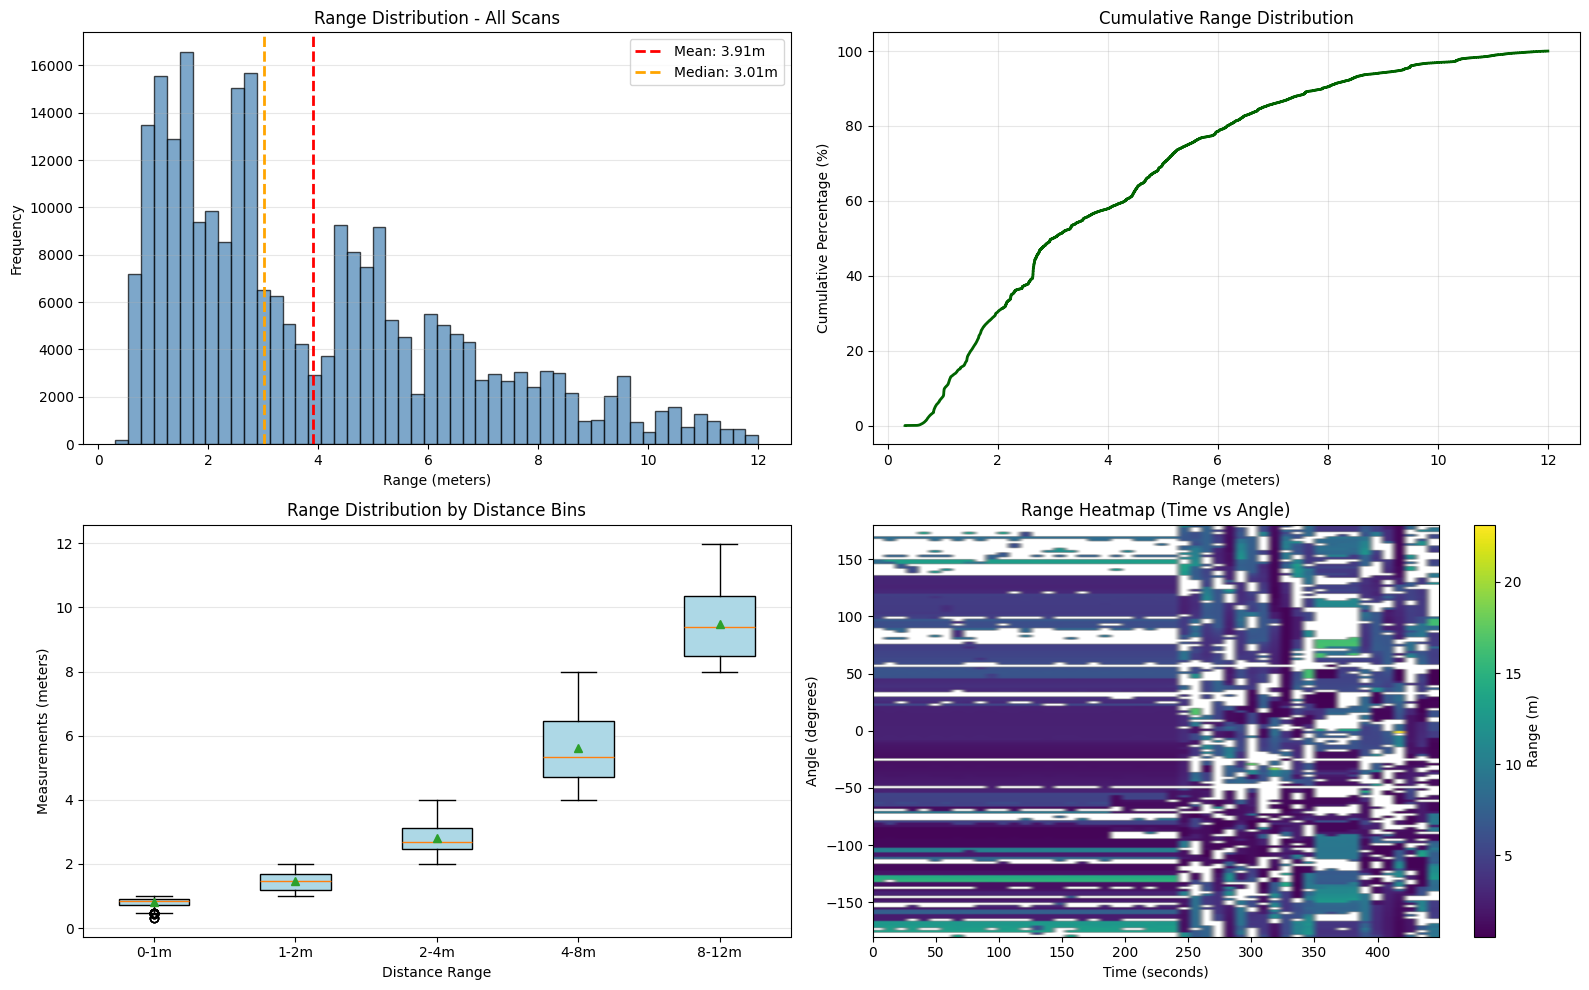


✅ Range distribution analysis saved to: range_distribution.png


In [22]:
# Analyze range distribution across all scans
print("=" * 60)
print("RANGE DISTRIBUTION ANALYSIS")
print("=" * 60)

if len(scans) > 0:
    # Collect all valid ranges
    all_ranges = []
    for scan in scans:
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        all_ranges.extend(scan[valid_mask])

    all_ranges = np.array(all_ranges)

    print(f"\n📊 Range Statistics:")
    print(f"   Total valid points: {len(all_ranges):,}")
    print(f"   Mean range: {np.mean(all_ranges):.2f} m")
    print(f"   Median range: {np.median(all_ranges):.2f} m")
    print(f"   Std dev: {np.std(all_ranges):.2f} m")
    print(f"   Min: {np.min(all_ranges):.2f} m")
    print(f"   Max: {np.max(all_ranges):.2f} m")

    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    percentile_values = np.percentile(all_ranges, percentiles)
    print(f"\n📈 Range Percentiles:")
    for p, v in zip(percentiles, percentile_values):
        print(f"   {p}th percentile: {v:.2f} m")

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Range histogram
    axes[0, 0].hist(all_ranges, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(np.mean(all_ranges), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(all_ranges):.2f}m')
    axes[0, 0].axvline(np.median(all_ranges), color='orange', linestyle='--', linewidth=2,
                       label=f'Median: {np.median(all_ranges):.2f}m')
    axes[0, 0].set_xlabel('Range (meters)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Range Distribution - All Scans')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Cumulative distribution
    sorted_ranges = np.sort(all_ranges)
    cumulative = np.arange(1, len(sorted_ranges) + 1) / len(sorted_ranges) * 100
    axes[0, 1].plot(sorted_ranges, cumulative, color='darkgreen', linewidth=2)
    axes[0, 1].set_xlabel('Range (meters)')
    axes[0, 1].set_ylabel('Cumulative Percentage (%)')
    axes[0, 1].set_title('Cumulative Range Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # Box plot by distance bins
    bins = [0, 1, 2, 4, 8, scan_params['range_max']]
    bin_labels = ['0-1m', '1-2m', '2-4m', '4-8m', f'8-{scan_params["range_max"]:.0f}m']
    binned_data = [all_ranges[(all_ranges >= bins[i]) & (all_ranges < bins[i+1])]
                   for i in range(len(bins)-1)]

    bp = axes[1, 0].boxplot([data for data in binned_data if len(data) > 0],
                   labels=[label for i, label in enumerate(bin_labels) if len(binned_data[i]) > 0],
                   showmeans=True, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    axes[1, 0].set_xlabel('Distance Range')
    axes[1, 0].set_ylabel('Measurements (meters)')
    axes[1, 0].set_title('Range Distribution by Distance Bins')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Heatmap: Range variation over time and angle (subsampled)
    subsample_scans = min(50, len(scans))
    subsample_angles = min(180, len(scans[0]))
    scan_indices = np.linspace(0, len(scans)-1, subsample_scans, dtype=int)
    angle_indices = np.linspace(0, len(scans[0])-1, subsample_angles, dtype=int)

    angles = np.arange(len(scans[0])) * scan_params['angle_increment'] + scan_params['angle_min']
    angles_deg = np.rad2deg(angles)

    heatmap_data = np.array([[scans[s][a] for a in angle_indices] for s in scan_indices])
    heatmap_data[~np.isfinite(heatmap_data)] = np.nan

    im = axes[1, 1].imshow(heatmap_data.T, aspect='auto', cmap='viridis',
                           extent=[scan_timestamps[scan_indices[0]], scan_timestamps[scan_indices[-1]],
                                   angles_deg[angle_indices[0]], angles_deg[angle_indices[-1]]],
                           origin='lower')
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Angle (degrees)')
    axes[1, 1].set_title('Range Heatmap (Time vs Angle)')
    plt.colorbar(im, ax=axes[1, 1], label='Range (m)')

    plt.tight_layout()
    plt.savefig('range_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Range distribution analysis saved to: range_distribution.png")
else:
    print("\n⚠️ No scans available for analysis")

### 4. Angular Coverage Analysis

ANGULAR COVERAGE ANALYSIS

📐 Angular Coverage Statistics:
   Total angles: 1147
   Angular resolution: 0.314°
   Coverage: 360.0°

   Angles with valid data: 1147/1147 (100.0%)
   Potential blind spots (<50% valid): 303 angles
   Blind spot angular ranges: [(np.float64(-180.00000500895632), np.float64(-179.68586886757583)), (np.float64(-130.36649467083905), np.float64(-130.05235852945856)), (np.float64(32.35602656425435), np.float64(32.670162705634844)), (np.float64(120.9424184335523), np.float64(136.96336164395726)), (np.float64(156.43980240954758), np.float64(156.75393855092807))]


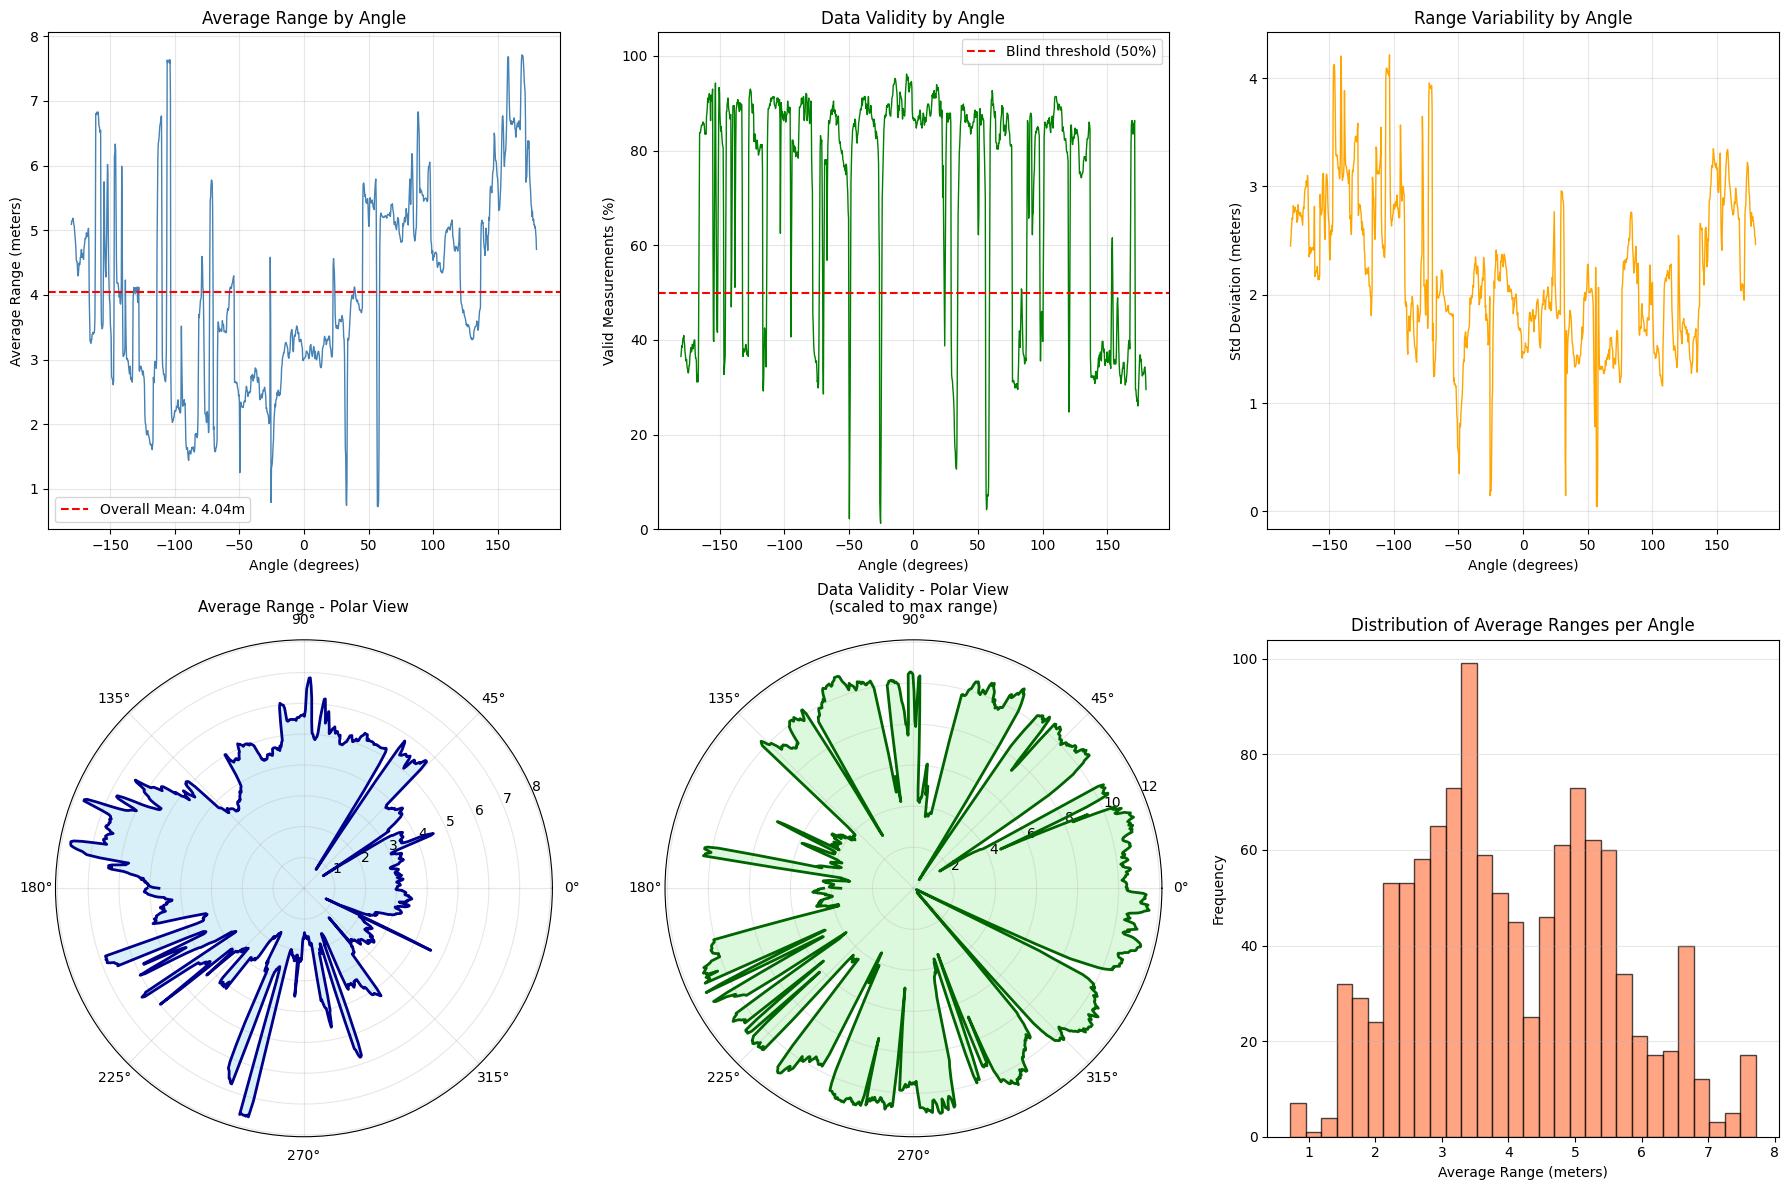


✅ Angular coverage analysis saved to: angular_coverage.png


In [23]:
# Analyze coverage across different angles
print("=" * 60)
print("ANGULAR COVERAGE ANALYSIS")
print("=" * 60)

if len(scans) > 0:
    # Calculate average range for each angle across all scans
    num_angles = len(scans[0])
    angles = np.arange(num_angles) * scan_params['angle_increment'] + scan_params['angle_min']
    angles_deg = np.rad2deg(angles)

    angle_ranges = []
    angle_valid_pct = []
    angle_std = []

    for angle_idx in range(num_angles):
        angle_data = [scan[angle_idx] for scan in scans]
        valid_mask = np.isfinite(angle_data) & (np.array(angle_data) >= scan_params['range_min']) & \
                     (np.array(angle_data) <= scan_params['range_max'])

        valid_data = np.array(angle_data)[valid_mask]
        angle_ranges.append(np.mean(valid_data) if len(valid_data) > 0 else np.nan)
        angle_valid_pct.append(np.sum(valid_mask) / len(scans) * 100)
        angle_std.append(np.std(valid_data) if len(valid_data) > 0 else np.nan)

    angle_ranges = np.array(angle_ranges)
    angle_valid_pct = np.array(angle_valid_pct)
    angle_std = np.array(angle_std)

    print(f"\n📐 Angular Coverage Statistics:")
    print(f"   Total angles: {num_angles}")
    print(f"   Angular resolution: {np.rad2deg(scan_params['angle_increment']):.3f}°")
    print(f"   Coverage: {np.rad2deg(scan_params['angle_max'] - scan_params['angle_min']):.1f}°")

    valid_angles = np.sum(~np.isnan(angle_ranges))
    print(f"\n   Angles with valid data: {valid_angles}/{num_angles} ({100*valid_angles/num_angles:.1f}%)")

    # Find blind spots (angles with low valid rate)
    blind_threshold = 50
    blind_angles = np.where(angle_valid_pct < blind_threshold)[0]
    print(f"   Potential blind spots (<{blind_threshold}% valid): {len(blind_angles)} angles")

    if len(blind_angles) > 0:
        blind_ranges = [(angles_deg[blind_angles[i]], angles_deg[blind_angles[min(i+1, len(blind_angles)-1)]])
                       for i in range(0, len(blind_angles), max(1, len(blind_angles)//5))]
        print(f"   Blind spot angular ranges: {blind_ranges[:5]}")

    # Plotting
    fig = plt.figure(figsize=(18, 12))

    # Average range by angle (linear)
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(angles_deg, angle_ranges, linewidth=1, color='steelblue')
    ax1.axhline(np.nanmean(angle_ranges), color='red', linestyle='--',
                label=f'Overall Mean: {np.nanmean(angle_ranges):.2f}m')
    ax1.set_xlabel('Angle (degrees)')
    ax1.set_ylabel('Average Range (meters)')
    ax1.set_title('Average Range by Angle')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Valid percentage by angle
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(angles_deg, angle_valid_pct, linewidth=1, color='green')
    ax2.axhline(blind_threshold, color='red', linestyle='--',
                label=f'Blind threshold ({blind_threshold}%)')
    ax2.set_xlabel('Angle (degrees)')
    ax2.set_ylabel('Valid Measurements (%)')
    ax2.set_title('Data Validity by Angle')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 105])

    # Standard deviation by angle
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(angles_deg, angle_std, linewidth=1, color='orange')
    ax3.set_xlabel('Angle (degrees)')
    ax3.set_ylabel('Std Deviation (meters)')
    ax3.set_title('Range Variability by Angle')
    ax3.grid(True, alpha=0.3)

    # Polar plot of average range
    ax4 = plt.subplot(2, 3, 4, projection='polar')
    ax4.plot(angles, angle_ranges, linewidth=2, color='darkblue')
    ax4.fill(angles, angle_ranges, alpha=0.3, color='skyblue')
    ax4.set_title('Average Range - Polar View', pad=20, fontsize=11)
    ax4.grid(True, alpha=0.3)

    # Polar plot of validity
    ax5 = plt.subplot(2, 3, 5, projection='polar')
    validity_normalized = angle_valid_pct / 100 * scan_params['range_max']
    ax5.plot(angles, validity_normalized, linewidth=2, color='darkgreen')
    ax5.fill(angles, validity_normalized, alpha=0.3, color='lightgreen')
    ax5.set_title('Data Validity - Polar View\n(scaled to max range)', pad=20, fontsize=11)
    ax5.grid(True, alpha=0.3)

    # Histogram of average ranges
    ax6 = plt.subplot(2, 3, 6)
    ax6.hist(angle_ranges[~np.isnan(angle_ranges)], bins=30, color='coral',
             edgecolor='black', alpha=0.7)
    ax6.set_xlabel('Average Range (meters)')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Distribution of Average Ranges per Angle')
    ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('angular_coverage.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Angular coverage analysis saved to: angular_coverage.png")
else:
    print("\n⚠️ No scans available for analysis")

### 5. Obstacle Detection Analysis

OBSTACLE DETECTION ANALYSIS

🚨 Safety Zone Statistics:
   Danger zone (<0.5m):
      Avg detections per scan: 0.1
      Max detections: 13
      Scans with danger: 4 (1.3%)

   Warning zone (0.5m-1.0m):
      Avg detections per scan: 61.8
      Scans with warnings: 277 (87.9%)

   Closest obstacle:
      Overall minimum: 0.31 m
      Average minimum: 0.79 m


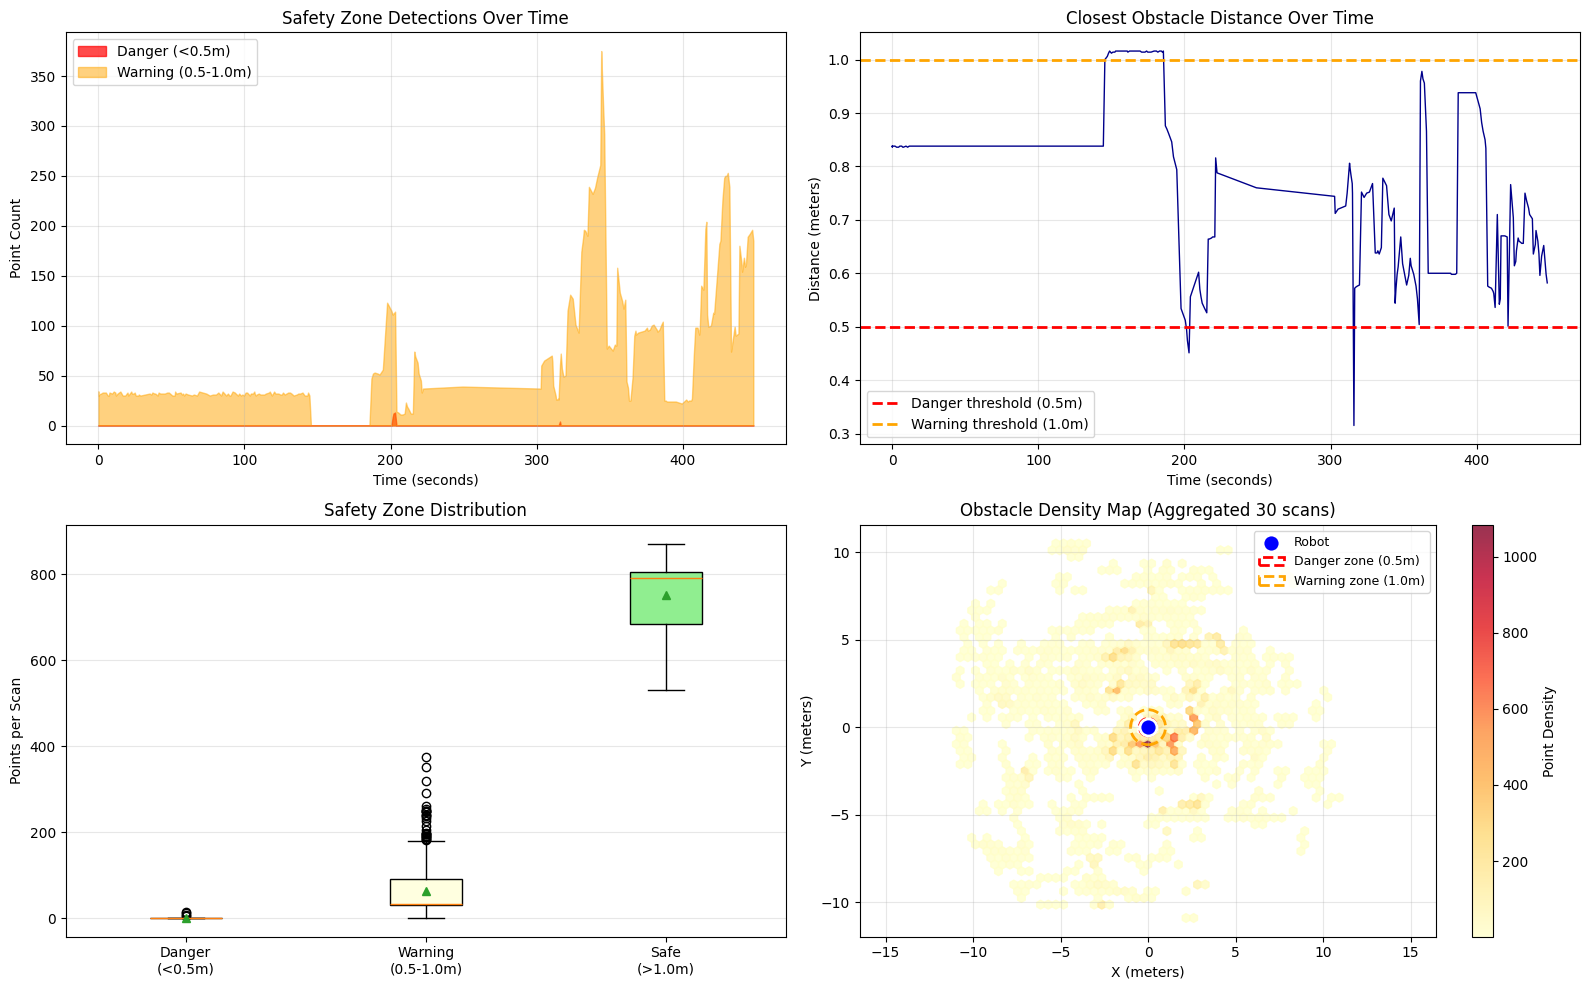


✅ Obstacle detection analysis saved to: obstacle_detection.png


In [24]:
# Analyze obstacles and safety zones
print("=" * 60)
print("OBSTACLE DETECTION ANALYSIS")
print("=" * 60)

if len(scans) > 0:
    # Define safety zones
    danger_zone = 0.5  # meters
    warning_zone = 1.0  # meters
    safe_zone = 2.0  # meters

    # Analyze each scan
    danger_counts = []
    warning_counts = []
    safe_counts = []
    closest_obstacles = []

    for scan in scans:
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        valid_ranges = scan[valid_mask]

        if len(valid_ranges) > 0:
            danger_counts.append(np.sum(valid_ranges < danger_zone))
            warning_counts.append(np.sum((valid_ranges >= danger_zone) & (valid_ranges < warning_zone)))
            safe_counts.append(np.sum(valid_ranges >= warning_zone))
            closest_obstacles.append(np.min(valid_ranges))
        else:
            danger_counts.append(0)
            warning_counts.append(0)
            safe_counts.append(0)
            closest_obstacles.append(np.nan)

    print(f"\n🚨 Safety Zone Statistics:")
    print(f"   Danger zone (<{danger_zone}m):")
    print(f"      Avg detections per scan: {np.mean(danger_counts):.1f}")
    print(f"      Max detections: {np.max(danger_counts)}")
    print(f"      Scans with danger: {np.sum(np.array(danger_counts) > 0)} ({100*np.sum(np.array(danger_counts) > 0)/len(scans):.1f}%)")

    print(f"\n   Warning zone ({danger_zone}m-{warning_zone}m):")
    print(f"      Avg detections per scan: {np.mean(warning_counts):.1f}")
    print(f"      Scans with warnings: {np.sum(np.array(warning_counts) > 0)} ({100*np.sum(np.array(warning_counts) > 0)/len(scans):.1f}%)")

    print(f"\n   Closest obstacle:")
    print(f"      Overall minimum: {np.nanmin(closest_obstacles):.2f} m")
    print(f"      Average minimum: {np.nanmean(closest_obstacles):.2f} m")

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Safety zones over time (stacked area)
    axes[0, 0].fill_between(scan_timestamps, 0, danger_counts,
                            alpha=0.7, label=f'Danger (<{danger_zone}m)', color='red')
    axes[0, 0].fill_between(scan_timestamps, 0, warning_counts,
                            alpha=0.5, label=f'Warning ({danger_zone}-{warning_zone}m)', color='orange')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Point Count')
    axes[0, 0].set_title('Safety Zone Detections Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Closest obstacle distance over time
    axes[0, 1].plot(scan_timestamps, closest_obstacles, linewidth=1, color='darkblue')
    axes[0, 1].axhline(danger_zone, color='red', linestyle='--', linewidth=2,
                       label=f'Danger threshold ({danger_zone}m)')
    axes[0, 1].axhline(warning_zone, color='orange', linestyle='--', linewidth=2,
                       label=f'Warning threshold ({warning_zone}m)')
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Distance (meters)')
    axes[0, 1].set_title('Closest Obstacle Distance Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Safety zone distribution (box plots)
    zone_data = [danger_counts, warning_counts, safe_counts]
    zone_labels = [f'Danger\n(<{danger_zone}m)',
                   f'Warning\n({danger_zone}-{warning_zone}m)',
                   f'Safe\n(>{warning_zone}m)']

    bp = axes[1, 0].boxplot(zone_data, labels=zone_labels, patch_artist=True,
                            showmeans=True)
    colors = ['lightcoral', 'lightyellow', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    axes[1, 0].set_ylabel('Points per Scan')
    axes[1, 0].set_title('Safety Zone Distribution')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Obstacle density map (aggregate multiple scans)
    all_x = []
    all_y = []

    sample_scans = min(30, len(scans))
    scan_step = len(scans) // sample_scans

    for i in range(0, len(scans), scan_step):
        if i >= len(scans):
            break
        scan = scans[i]
        angles = np.arange(len(scan)) * scan_params['angle_increment'] + scan_params['angle_min']
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        valid_ranges = scan[valid_mask]
        valid_angles = angles[valid_mask]

        x = valid_ranges * np.cos(valid_angles)
        y = valid_ranges * np.sin(valid_angles)
        all_x.extend(x)
        all_y.extend(y)

    h = axes[1, 1].hexbin(all_x, all_y, gridsize=50, cmap='YlOrRd', mincnt=1, alpha=0.8)
    axes[1, 1].scatter(0, 0, c='blue', s=150, marker='o', label='Robot', zorder=5, edgecolors='white', linewidths=2)

    # Draw safety circles
    circle_danger = plt.Circle((0, 0), danger_zone, fill=False, color='red',
                               linestyle='--', linewidth=2, label=f'Danger zone ({danger_zone}m)')
    circle_warning = plt.Circle((0, 0), warning_zone, fill=False, color='orange',
                                linestyle='--', linewidth=2, label=f'Warning zone ({warning_zone}m)')
    axes[1, 1].add_patch(circle_danger)
    axes[1, 1].add_patch(circle_warning)

    axes[1, 1].set_xlabel('X (meters)')
    axes[1, 1].set_ylabel('Y (meters)')
    axes[1, 1].set_title(f'Obstacle Density Map (Aggregated {sample_scans} scans)')
    axes[1, 1].axis('equal')
    axes[1, 1].legend(loc='upper right', fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(h, ax=axes[1, 1], label='Point Density')

    plt.tight_layout()
    plt.savefig('obstacle_detection.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Obstacle detection analysis saved to: obstacle_detection.png")
else:
    print("\n⚠️ No scans available for analysis")

### 6. Scan Timing and Quality Metrics

SCAN TIMING AND QUALITY METRICS

⏱️ Timing Statistics:
   Mean interval: 1427.87 ms
   Std dev: 3374.64 ms
   Min/Max: [0.02, 53541.24] ms
   Jitter (CV): 236.34%

📡 Frequency Statistics:
   Mean frequency: 1745.18 Hz
   Expected frequency: 7.46 Hz
   Frequency error: 1737.73 Hz (23299.8%)

⚠️ Dropped Scans:
   Potential drops: 293 (93.31%)

📊 Computing quality metrics...


100%|██████████| 315/315 [00:00<00:00, 13066.37it/s]


✓ Quality Metrics Summary:
   Mean completeness: 70.97%
   Mean noise level: 0.1385 m
   Overall quality score: 0.710/1.000


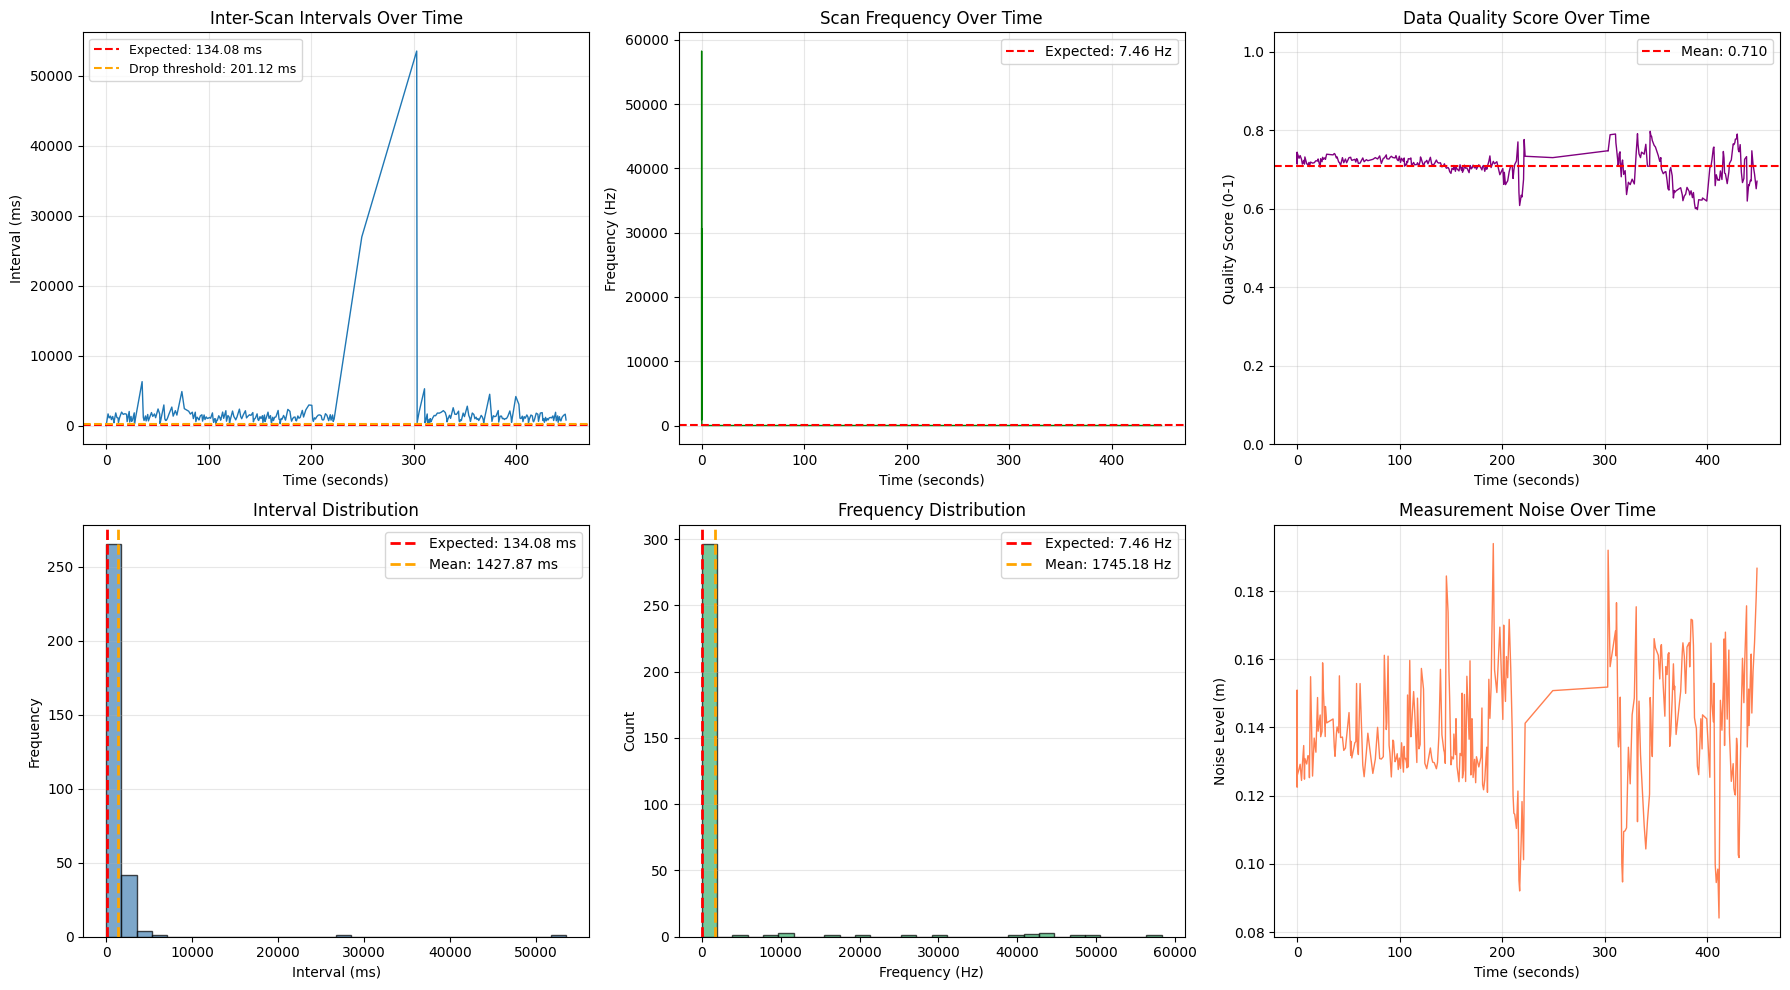


✅ Timing and quality analysis saved to: timing_quality_metrics.png


In [25]:
# Analyze scan frequency and data quality
print("=" * 60)
print("SCAN TIMING AND QUALITY METRICS")
print("=" * 60)

if len(scan_timestamps) > 1:
    # Timing analysis
    intervals = np.diff(scan_timestamps)
    frequencies = 1.0 / intervals

    expected_interval = scan_params['scan_time']
    expected_freq = 1.0 / expected_interval if expected_interval > 0 else 10

    print(f"\n⏱️ Timing Statistics:")
    print(f"   Mean interval: {np.mean(intervals)*1000:.2f} ms")
    print(f"   Std dev: {np.std(intervals)*1000:.2f} ms")
    print(f"   Min/Max: [{np.min(intervals)*1000:.2f}, {np.max(intervals)*1000:.2f}] ms")
    print(f"   Jitter (CV): {(np.std(intervals)/np.mean(intervals))*100:.2f}%")

    print(f"\n📡 Frequency Statistics:")
    print(f"   Mean frequency: {np.mean(frequencies):.2f} Hz")
    print(f"   Expected frequency: {expected_freq:.2f} Hz")
    print(f"   Frequency error: {abs(np.mean(frequencies) - expected_freq):.2f} Hz ({abs(np.mean(frequencies) - expected_freq)/expected_freq*100:.1f}%)")

    # Dropped scans
    dropped_threshold = expected_interval * 1.5
    dropped_count = np.sum(intervals > dropped_threshold)
    print(f"\n⚠️ Dropped Scans:")
    print(f"   Potential drops: {dropped_count} ({100*dropped_count/len(intervals):.2f}%)")

    # Quality metrics per scan
    print("\n📊 Computing quality metrics...")

    quality_scores = []
    noise_levels = []

    for scan in tqdm(scans):
        valid_mask = np.isfinite(scan) & (scan >= scan_params['range_min']) & (scan <= scan_params['range_max'])
        valid_ranges = scan[valid_mask]

        # Completeness score
        completeness = np.sum(valid_mask) / len(scan)

        # Noise level (high-frequency changes)
        if len(valid_ranges) > 1:
            diffs = np.abs(np.diff(valid_ranges))
            noise = np.mean(diffs)
            noise_levels.append(noise)
        else:
            noise_levels.append(np.nan)

        # Combined quality score (simple: just completeness for now)
        quality_scores.append(completeness)

    quality_scores = np.array(quality_scores)
    noise_levels = np.array(noise_levels)

    print(f"\n✓ Quality Metrics Summary:")
    print(f"   Mean completeness: {np.mean(quality_scores)*100:.2f}%")
    print(f"   Mean noise level: {np.nanmean(noise_levels):.4f} m")
    print(f"   Overall quality score: {np.mean(quality_scores):.3f}/1.000")

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Scan intervals over time
    axes[0, 0].plot(scan_timestamps[1:], intervals * 1000, linewidth=1)
    axes[0, 0].axhline(expected_interval * 1000, color='red', linestyle='--',
                       label=f'Expected: {expected_interval*1000:.2f} ms')
    axes[0, 0].axhline(dropped_threshold * 1000, color='orange', linestyle='--',
                       label=f'Drop threshold: {dropped_threshold*1000:.2f} ms')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Interval (ms)')
    axes[0, 0].set_title('Inter-Scan Intervals Over Time')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)

    # Frequency over time
    axes[0, 1].plot(scan_timestamps[1:], frequencies, linewidth=1, color='green')
    axes[0, 1].axhline(expected_freq, color='red', linestyle='--',
                       label=f'Expected: {expected_freq:.2f} Hz')
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Frequency (Hz)')
    axes[0, 1].set_title('Scan Frequency Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Quality score over time
    axes[0, 2].plot(scan_timestamps, quality_scores, linewidth=1, color='purple')
    axes[0, 2].axhline(np.mean(quality_scores), color='red', linestyle='--',
                       label=f'Mean: {np.mean(quality_scores):.3f}')
    axes[0, 2].set_xlabel('Time (seconds)')
    axes[0, 2].set_ylabel('Quality Score (0-1)')
    axes[0, 2].set_title('Data Quality Score Over Time')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim([0, 1.05])

    # Interval histogram
    axes[1, 0].hist(intervals * 1000, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(expected_interval * 1000, color='red', linestyle='--', linewidth=2,
                       label=f'Expected: {expected_interval*1000:.2f} ms')
    axes[1, 0].axvline(np.mean(intervals) * 1000, color='orange', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(intervals)*1000:.2f} ms')
    axes[1, 0].set_xlabel('Interval (ms)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Interval Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Frequency histogram
    axes[1, 1].hist(frequencies, bins=30, color='mediumseagreen', edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(expected_freq, color='red', linestyle='--', linewidth=2,
                       label=f'Expected: {expected_freq:.2f} Hz')
    axes[1, 1].axvline(np.mean(frequencies), color='orange', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(frequencies):.2f} Hz')
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Frequency Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Noise level over time
    axes[1, 2].plot(scan_timestamps, noise_levels, linewidth=1, color='coral')
    axes[1, 2].set_xlabel('Time (seconds)')
    axes[1, 2].set_ylabel('Noise Level (m)')
    axes[1, 2].set_title('Measurement Noise Over Time')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('timing_quality_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Timing and quality analysis saved to: timing_quality_metrics.png")
else:
    print("\n⚠️ Insufficient data for timing analysis")

### 7. LiDAR Scan EDA Summary Report

In [26]:
# Generate comprehensive LiDAR Scan EDA summary
print("=" * 60)
print("LIDAR SCAN EDA - SUMMARY REPORT")
print("=" * 60)

if len(scans) > 0 and len(all_ranges) > 0:
    lidar_scan_summary = f"""
🔵 LIDAR SCAN EDA SUMMARY
{'='*60}

BASIC INFORMATION:
  • Topic: {lidar_topic}
  • Total Scans: {len(scans)}
  • Duration: {scan_timestamps[-1]:.2f} seconds ({scan_timestamps[-1]/60:.2f} minutes)
  • Average Scan Rate: {len(scans)/scan_timestamps[-1]:.2f} Hz
  • Expected Scan Rate: {expected_freq:.2f} Hz

SENSOR CONFIGURATION:
  • Points per Scan: {len(scans[0])}
  • Angular Coverage: {np.rad2deg(scan_params['angle_max'] - scan_params['angle_min']):.1f}°
  • Angular Resolution: {np.rad2deg(scan_params['angle_increment']):.3f}°
  • Range: [{scan_params['range_min']:.2f}m - {scan_params['range_max']:.2f}m]
  • Scan Time: {scan_params['scan_time']:.4f} s

RANGE STATISTICS:
  • Total Valid Points: {len(all_ranges):,}
  • Mean Range: {np.mean(all_ranges):.2f} m
  • Median Range: {np.median(all_ranges):.2f} m
  • Std Deviation: {np.std(all_ranges):.2f} m
  • Min/Max Range: [{np.min(all_ranges):.2f}m, {np.max(all_ranges):.2f}m]

DATA QUALITY:
  • Average Completeness: {np.mean(quality_scores)*100:.2f}%
  • Average Valid Points per Scan: {np.mean(valid_counts):.1f} ({100*np.mean(valid_counts)/len(scans[0]):.1f}%)
  • Average Invalid Points per Scan: {np.mean(invalid_counts):.1f} ({100*np.mean(invalid_counts)/len(scans[0]):.1f}%)
  • Overall Quality Score: {np.mean(quality_scores):.3f}/1.000
  • Average Noise Level: {np.nanmean(noise_levels):.4f} m

TIMING ANALYSIS:
  • Mean Scan Interval: {np.mean(intervals)*1000:.2f} ms
  • Timing Jitter (CV): {(np.std(intervals)/np.mean(intervals))*100:.2f}%
  • Potential Dropped Scans: {dropped_count} ({100*dropped_count/len(intervals):.2f}%)
  • Frequency Error: {abs(np.mean(frequencies) - expected_freq)/expected_freq*100:.2f}%

OBSTACLE DETECTION:
  • Closest Obstacle (Overall): {np.nanmin(closest_obstacles):.2f} m
  • Average Closest Obstacle: {np.nanmean(closest_obstacles):.2f} m
  • Danger Zone Detections (<{danger_zone}m): {np.sum(np.array(danger_counts) > 0)} scans ({100*np.sum(np.array(danger_counts) > 0)/len(scans):.1f}%)
  • Warning Zone Detections ({danger_zone}-{warning_zone}m): {np.sum(np.array(warning_counts) > 0)} scans ({100*np.sum(np.array(warning_counts) > 0)/len(scans):.1f}%)

ANGULAR COVERAGE:
  • Angles with Valid Data: {int(np.sum(valid_angles))}/{num_angles} ({100*np.sum(valid_angles)/num_angles:.1f}%)
  • Potential Blind Spots (<{blind_threshold}% valid): {len(blind_angles)} angles

OUTPUT FILES:
  • sample_scans_polar.png
  • sample_scans_cartesian.png
  • scan_properties.png
  • range_distribution.png
  • angular_coverage.png
  • obstacle_detection.png
  • timing_quality_metrics.png
"""

    print(lidar_scan_summary)

    # Save summary report
    with open('lidar_scan_eda_summary.txt', 'w') as f:
        f.write(lidar_scan_summary)

    print("\n✅ LiDAR Scan EDA summary saved to: lidar_scan_eda_summary.txt")
else:
    print("\n⚠️ No scan data available for summary")

LIDAR SCAN EDA - SUMMARY REPORT

🔵 LIDAR SCAN EDA SUMMARY

BASIC INFORMATION:
  • Topic: /scan
  • Total Scans: 315
  • Duration: 448.35 seconds (7.47 minutes)
  • Average Scan Rate: 0.70 Hz
  • Expected Scan Rate: 7.46 Hz

SENSOR CONFIGURATION:
  • Points per Scan: 1147
  • Angular Coverage: 360.0°
  • Angular Resolution: 0.314°
  • Range: [0.15m - 12.00m]
  • Scan Time: 0.1341 s

RANGE STATISTICS:
  • Total Valid Points: 256,402
  • Mean Range: 3.91 m
  • Median Range: 3.01 m
  • Std Deviation: 2.64 m
  • Min/Max Range: [0.31m, 12.00m]

DATA QUALITY:
  • Average Completeness: 70.97%
  • Average Valid Points per Scan: 814.0 (71.0%)
  • Average Invalid Points per Scan: 333.0 (29.0%)
  • Overall Quality Score: 0.710/1.000
  • Average Noise Level: 0.1385 m

TIMING ANALYSIS:
  • Mean Scan Interval: 1427.87 ms
  • Timing Jitter (CV): 236.34%
  • Potential Dropped Scans: 293 (93.31%)
  • Frequency Error: 23299.84%

OBSTACLE DETECTION:
  • Closest Obstacle (Overall): 0.31 m
  • Average Close